In [2]:
%load_ext autoreload
%autoreload 2

import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import iqr
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS
from astropy.time import Time
from astropy.timeseries import LombScargle
from astropy.wcs import WCS
from astropy import units as u
from astropy.io import fits
from astropy import constants
from astropy.modeling.models import BlackBody
from astropy.visualization import quantity_support

import missingno as missno
from tqdm import tqdm

In [3]:
#Move up to RAFTS directory
if os.getcwd().endswith('/RAFTS'):
    pass
else:
    os.chdir('..')

In [4]:

from config import *

from utils import filt_interp, dpar, dtan, lamb_eff_md, dcr_offset, celest_to_pa, inverse_Teff, inverseTeff, inverseWeff, lorentzian, chrDistAng
import globals

In [5]:
SAVE = False
D2ARCSEC = 3_600
DAY2SEC = 24 * 3_600


In [6]:
!pwd

/Users/fbianco/RAFTS


In [7]:
#PARAMS
flare_ref_pos = np.array([323.0, 429.5])

filters = ['u', 'g', 'r', 'i', 'z', 'y']

filtercolors = {
            "u": "#66CCEE",
            "g": "#228833",
            "r": "#CCBB44",
            "i": "#EE6677",
            "z": "#AA3377",
            "y": "#4B3713",
            " ": None}

In [8]:
main_df = pd.read_csv("Outdata/main_df.csv")
main_df

,Unnamed: 0,id,group_id,local_bkg,x_init,y_init,flux_init,x_fit,y_fit,flux_fit,...,npixfit,group_size,qfit,cfit,flags,RA,DEC,RA_ERR,DEC_ERR,time
0,0,1.0,1.0,33.343352,868.889639,20.951553,106993.565293,868.892499,21.098664,186635.970123,...,625.0,1.0,0.762559,0.016628,0.0,45.554976,-54.992271,0.000028,0.000016,57374.240660
1,12,83.0,83.0,23.082433,422.296971,2961.112249,3672.672931,422.150798,2961.159211,3379.534100,...,625.0,1.0,0.971775,0.015758,0.0,45.928673,-54.957625,0.000032,0.000018,57374.240660
2,1,82.0,82.0,25.523977,139.642302,2955.204949,19211.044234,139.604271,2955.281047,30754.254403,...,625.0,1.0,0.802317,0.017940,0.0,45.927397,-54.936999,0.000030,0.000017,57374.240660
3,2,81.0,81.0,24.100240,268.476611,2924.354760,9791.394575,268.463994,2924.433983,14044.020139,...,625.0,1.0,0.835777,0.017905,0.0,45.923717,-54.946434,0.000030,0.000017,57374.240660
4,54,56.0,56.0,23.282809,434.574708,1938.966299,2357.553873,434.192095,1939.042643,959.637945,...,625.0,1.0,1.842647,0.027675,0.0,45.798681,-54.959317,0.000052,0.000029,57374.240660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7295,7295,30.0,32.0,57.001349,1824.854811,1213.422659,37845.622864,1824.294438,1213.662755,63338.046493,...,625.0,1.0,0.864397,0.014717,0.0,45.708541,-55.061557,0.000034,0.000019,57374.281315
7296,7296,29.0,31.0,31.808931,1379.157141,1176.361369,42205.610583,1379.115846,1176.489644,73917.454394,...,625.0,1.0,0.791725,0.014856,0.0,45.703176,-55.029038,0.000033,0.000019,57374.281315
7297,7297,28.0,30.0,32.753714,330.811478,1164.599307,30151.492830,330.796552,1164.731394,51061.844600,...,625.0,1.0,0.810259,0.014200,0.0,45.700205,-54.952445,0.000033,0.000019,57374.281315
7298,7228,55.0,57.0,28.577646,1131.609837,1905.121661,5430.025473,1131.593416,1905.278546,5726.640362,...,625.0,1.0,1.022623,0.019107,0.0,45.795734,-55.010454,0.000041,0.000023,57374.281315


In [9]:
flr_id = 11

In [10]:
display(main_df[main_df['id'] == flr_id])

,Unnamed: 0,id,group_id,local_bkg,x_init,y_init,flux_init,x_fit,y_fit,flux_fit,...,npixfit,group_size,qfit,cfit,flags,RA,DEC,RA_ERR,DEC_ERR,time
71,71,11.0,11.0,23.205445,320.609651,428.992096,2376.580928,320.632378,429.042347,1027.231919,...,625.0,1.0,1.666292,0.017357,0.0,45.606310,-54.951992,0.000046,0.000026,57374.240660
366,367,11.0,11.0,22.622928,320.445774,429.464169,2314.052575,320.231374,429.698961,1011.509538,...,625.0,1.0,1.638300,0.019332,0.0,45.606350,-54.951985,0.000052,0.000029,57374.242328
473,473,11.0,13.0,21.484964,320.963110,428.407932,2389.650484,320.817316,428.605051,1379.440040,...,625.0,1.0,1.270640,0.017724,0.0,45.606358,-54.951991,0.000036,0.000020,57374.242878
572,572,11.0,13.0,22.801374,320.993946,428.131239,2308.515674,320.803206,428.441936,929.501917,...,625.0,1.0,1.852900,0.019851,0.0,45.606353,-54.951977,0.000057,0.000032,57374.243432
667,668,11.0,12.0,22.459800,320.984981,428.186120,2306.726342,321.409020,428.272199,1019.880413,...,625.0,1.0,1.766088,0.020940,0.0,45.606299,-54.952010,0.000049,0.000027,57374.244000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6889,6894,11.0,11.0,26.651665,320.227083,427.290883,3545.589688,320.243422,427.547101,2777.467436,...,625.0,1.0,1.000124,0.014215,0.0,45.606366,-54.951997,0.000043,0.000024,57374.279094
6968,6989,11.0,11.0,26.684314,320.357455,428.162025,3440.164793,320.296185,428.493803,2725.231354,...,625.0,1.0,0.951375,0.008849,0.0,45.606362,-54.951993,0.000044,0.000025,57374.279650
7072,7074,11.0,11.0,26.834987,319.850318,427.045720,3529.139337,319.850625,427.365180,2651.361680,...,625.0,1.0,1.032413,0.016728,0.0,45.606358,-54.951986,0.000039,0.000022,57374.280204
7158,7169,11.0,11.0,26.829193,319.657690,427.766516,3504.598482,319.693049,428.008806,2582.148306,...,625.0,1.0,1.086400,0.016934,0.0,45.606387,-54.951998,0.000039,0.000022,57374.280761


(array([ 3.,  0.,  2.,  2.,  2.,  1.,  4.,  1.,  8., 87.]),
 array([  1.35135135,  11.21621622,  21.08108108,  30.94594595,
         40.81081081,  50.67567568,  60.54054054,  70.40540541,
         80.27027027,  90.13513514, 100.        ]),
 <BarContainer object of 10 artists>)

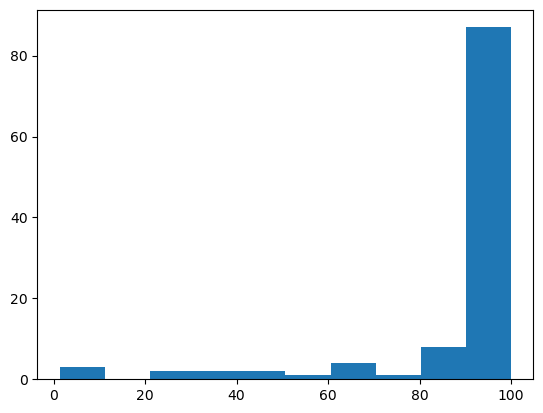

In [11]:
m = []

for id in main_df['id'].unique():
    m.append((main_df[main_df['id'] == id].shape[0] / 74) * 100)

m = np.array(m)
plt.hist(m)

In [12]:
len(m[m == 100.0])

49

In [13]:
len(m[m > 80])

95

<Axes: xlabel='time'>

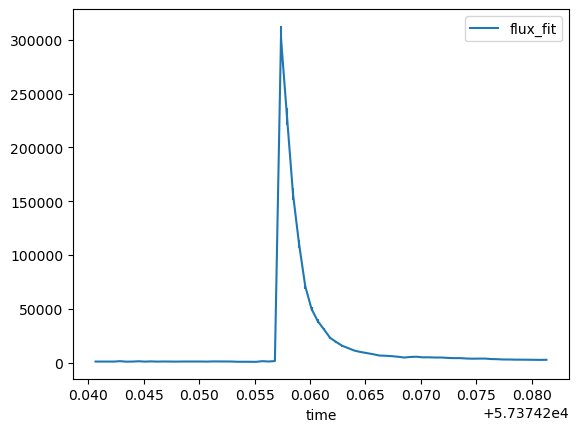

In [14]:
main_df[main_df['id'] == flr_id].plot(x = 'time', y='flux_fit', yerr='flux_err')

In [15]:
t_index = []
for i, time in enumerate(main_df['time'].dropna().unique()):

    if (main_df['time'][main_df['id'] == flr_id].values == time).any():
        t_index.append(True)

    else:
        t_index.append(False) 

In [16]:
len(t_index)

74

In [17]:
g_flux = main_df[main_df['id'] == flr_id]['flux_fit']
g_flux_err = main_df[main_df['id'] == flr_id]['flux_err']
flr_times = main_df[main_df['id'] == flr_id]['time']
g_mag = 22.5 - 2.5 * np.log10(g_flux.values)
g_mag_err = (2.5/np.log(10)) * (g_flux_err/g_flux)
g_mag_err = g_mag_err.values
delta_g_mag = g_mag - np.mean(g_mag[((flr_times - flr_times.iloc[0]) * DAY2SEC) < 1000])
delta_g_mag_err = g_mag_err - np.sqrt(np.sum(g_mag_err[((flr_times - flr_times.iloc[0]) * DAY2SEC) < 1000] ** 2)) /  len(g_mag_err[((flr_times - flr_times.iloc[0]) * DAY2SEC) < 1000])


for i, t in enumerate(t_index):
    if not t:
        delta_g_mag = np.insert(delta_g_mag, i, np.nan)
        delta_g_mag_err = np.insert(delta_g_mag_err, i, np.nan)
    else:
        pass

delta_g_mag, delta_g_mag_err

(array([ 4.50540586e-02,             nan,             nan,  6.18003671e-02,
        -2.75031746e-01,  1.53599598e-01,  5.28521951e-02, -2.06404632e-01,
         9.97016979e-02, -1.09199890e-01,  9.59371004e-02, -1.93514136e-02,
                    nan,  1.02343554e-01,  1.59777841e-02,             nan,
                    nan,  5.61083883e-03,  1.00573270e-01, -7.53870994e-02,
        -4.80756832e-02, -1.78392940e-02,  1.22433058e-02,  2.76158036e-01,
                    nan,  2.72314214e-01,  3.80101782e-01, -2.86631927e-01,
         1.46376557e-03, -3.65414442e-01, -6.12486939e+00, -5.82499183e+00,
        -5.41354601e+00, -5.03078173e+00, -4.55342130e+00, -4.17228568e+00,
        -3.89542434e+00, -3.66042475e+00, -3.33475428e+00, -3.13259622e+00,
        -2.91099073e+00, -2.74375166e+00, -2.54332689e+00, -2.41273437e+00,
        -2.29597276e+00, -2.15847218e+00, -1.98008144e+00, -1.94049208e+00,
        -1.87694650e+00, -1.77485261e+00, -1.62054447e+00, -1.73878246e+00,
        -1.7

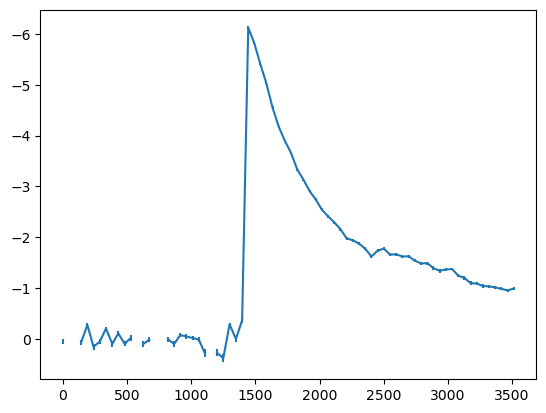

In [18]:
times = main_df['time'].dropna().unique() 
# you were doing this subtraction and the conversion to second 50 times and then you were creating this variable way below...
tSec = (times - times[0]) * DAY2SEC
plt.errorbar(tSec, delta_g_mag, yerr=delta_g_mag_err)
plt.gca().invert_yaxis()

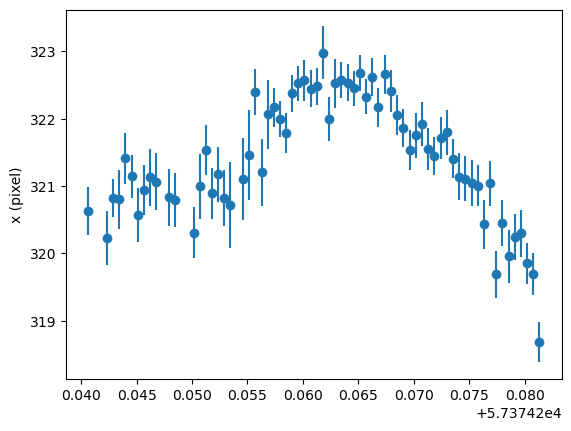

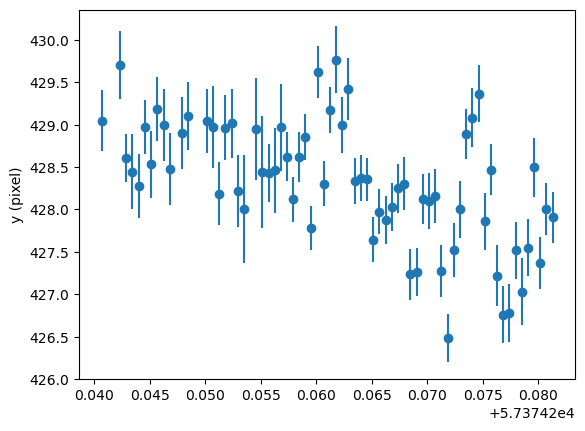

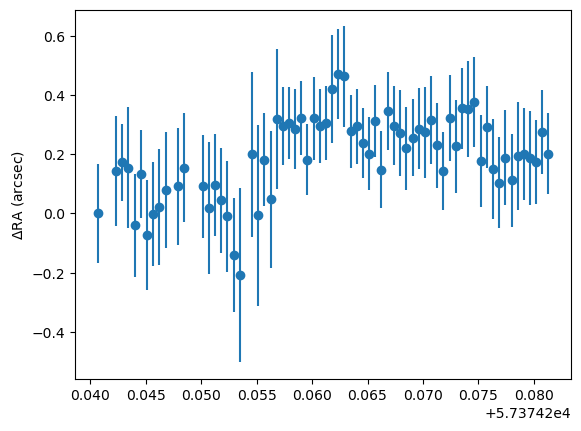

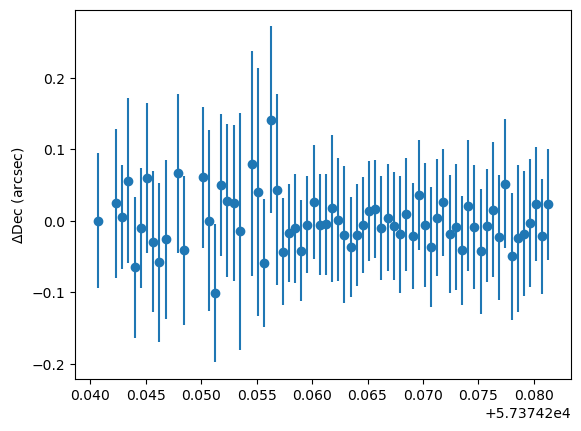

In [19]:
plt.errorbar(main_df['time'][main_df['id'] == flr_id], main_df['x_fit'][main_df['id'] == flr_id], yerr = main_df['x_err'][main_df['id'] == flr_id], marker='o', ls='None')
plt.ylabel('x (pixel)')
plt.show()

plt.errorbar(main_df['time'][main_df['id'] == flr_id], main_df['y_fit'][main_df['id'] == flr_id], yerr = main_df['y_err'][main_df['id'] == flr_id], marker='o', ls='None')
plt.ylabel('y (pixel)')
plt.show()

plt.errorbar(main_df['time'][main_df['id'] == flr_id], (main_df['RA'][main_df['id'] == flr_id] - main_df['RA'][main_df['id'] == flr_id].iloc[0]) * D2ARCSEC, yerr = main_df['RA_ERR'][main_df['id'] == 11] * D2ARCSEC, marker='o', ls='None')
plt.ylabel(r'$\Delta$RA (arcsec)')
plt.show()

plt.errorbar(main_df['time'][main_df['id'] == flr_id], (main_df['DEC'][main_df['id'] == flr_id] - main_df['DEC'][main_df['id'] == flr_id].iloc[0]) * D2ARCSEC, yerr = main_df['DEC_ERR'][main_df['id'] == 11] * D2ARCSEC, marker='o', ls='None')
plt.ylabel(r'$\Delta$Dec (arcsec)')
plt.show()

In [20]:
main_df

,Unnamed: 0,id,group_id,local_bkg,x_init,y_init,flux_init,x_fit,y_fit,flux_fit,...,npixfit,group_size,qfit,cfit,flags,RA,DEC,RA_ERR,DEC_ERR,time
0,0,1.0,1.0,33.343352,868.889639,20.951553,106993.565293,868.892499,21.098664,186635.970123,...,625.0,1.0,0.762559,0.016628,0.0,45.554976,-54.992271,0.000028,0.000016,57374.240660
1,12,83.0,83.0,23.082433,422.296971,2961.112249,3672.672931,422.150798,2961.159211,3379.534100,...,625.0,1.0,0.971775,0.015758,0.0,45.928673,-54.957625,0.000032,0.000018,57374.240660
2,1,82.0,82.0,25.523977,139.642302,2955.204949,19211.044234,139.604271,2955.281047,30754.254403,...,625.0,1.0,0.802317,0.017940,0.0,45.927397,-54.936999,0.000030,0.000017,57374.240660
3,2,81.0,81.0,24.100240,268.476611,2924.354760,9791.394575,268.463994,2924.433983,14044.020139,...,625.0,1.0,0.835777,0.017905,0.0,45.923717,-54.946434,0.000030,0.000017,57374.240660
4,54,56.0,56.0,23.282809,434.574708,1938.966299,2357.553873,434.192095,1939.042643,959.637945,...,625.0,1.0,1.842647,0.027675,0.0,45.798681,-54.959317,0.000052,0.000029,57374.240660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7295,7295,30.0,32.0,57.001349,1824.854811,1213.422659,37845.622864,1824.294438,1213.662755,63338.046493,...,625.0,1.0,0.864397,0.014717,0.0,45.708541,-55.061557,0.000034,0.000019,57374.281315
7296,7296,29.0,31.0,31.808931,1379.157141,1176.361369,42205.610583,1379.115846,1176.489644,73917.454394,...,625.0,1.0,0.791725,0.014856,0.0,45.703176,-55.029038,0.000033,0.000019,57374.281315
7297,7297,28.0,30.0,32.753714,330.811478,1164.599307,30151.492830,330.796552,1164.731394,51061.844600,...,625.0,1.0,0.810259,0.014200,0.0,45.700205,-54.952445,0.000033,0.000019,57374.281315
7298,7228,55.0,57.0,28.577646,1131.609837,1905.121661,5430.025473,1131.593416,1905.278546,5726.640362,...,625.0,1.0,1.022623,0.019107,0.0,45.795734,-55.010454,0.000041,0.000023,57374.281315


<Axes: >

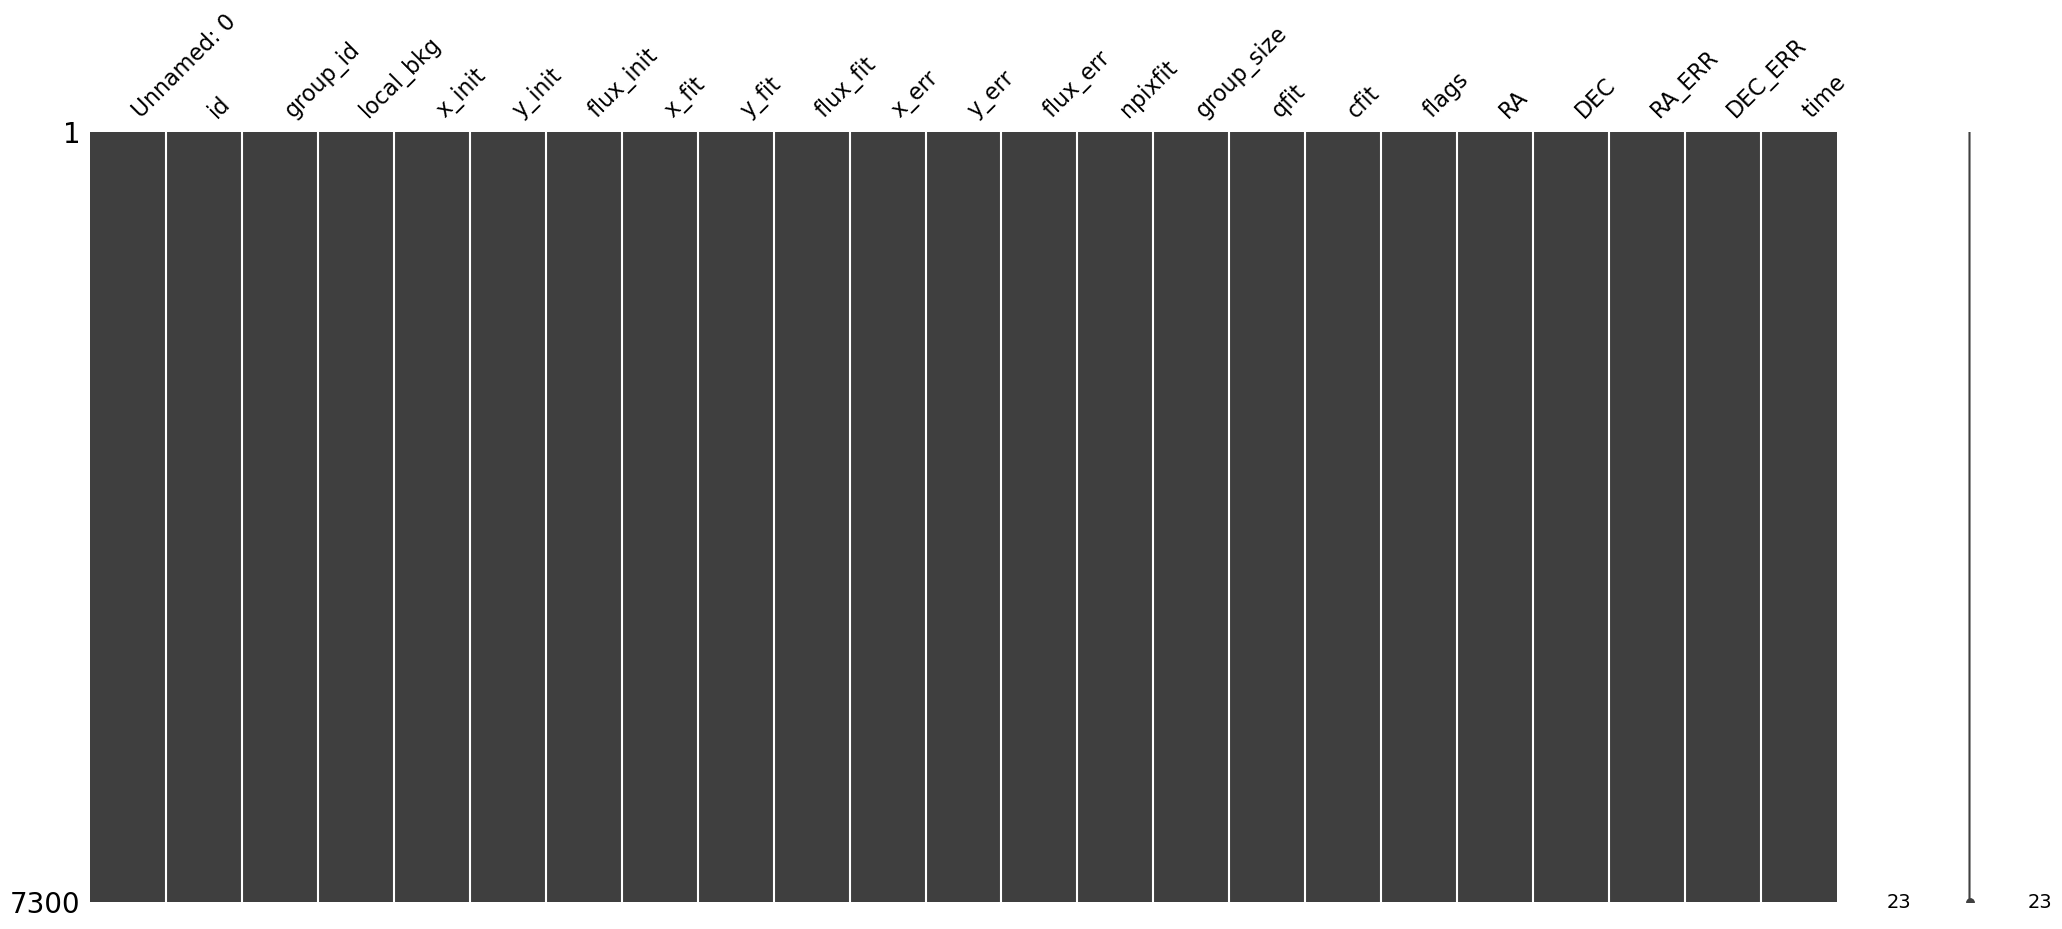

In [21]:
missno.matrix(main_df)

In [22]:
# FBB cleaning maindf 
main_df = main_df.dropna(how="all")


In [23]:
# FBB moved here because it uses main_df - soon you will make arrays and can use only ghose
#airmass of flare object at all epochs
flr_am = SkyCoord(ra = main_df['RA'][main_df['id'] == flr_id], dec = main_df['DEC'][main_df['id'] == flr_id], 
         unit=u.deg, obstime=Time(main_df['time'][main_df['id'] == flr_id].values, format='mjd'), 
                  location=EarthLocation.of_site('Cerro Tololo')).transform_to(AltAz).secz.value

flr_am.min(), flr_am.max(), 

(1.4607135736674501, 1.752918613663072)

In [24]:
#epochs when the flare star is observed
dt_sec = (main_df['time'][main_df['id'] == flr_id] - main_df['time'][main_df['id'] == flr_id].iloc[0]) * DAY2SEC
print(f"Epochs with flare star detections: {dt_sec.shape[0]}")

Epochs with flare star detections: 68


In [25]:
if SAVE:
    np.save('Outdata/dt_sec.npy', dt_sec)

In [26]:
ras = np.zeros((74, 110)) #74 time stamps, 110 stars RA in deg
decs = np.zeros((74, 110)) #74 time stamps, 110 stars Dec in deg

for j, id in (enumerate(np.sort(main_df['id'].dropna().unique()))): #for every star
    print(f"star id {j}")
    for i, t in (enumerate(main_df['time'].dropna().unique())): #for every time stamp
        if main_df['RA'][(main_df['id'] == id) * (main_df['time'] == t)].dropna().values:
            ras[i,j] = main_df['RA'][(main_df['id'] == id) * (main_df['time'] == t)].dropna().values
            decs[i,j] = main_df['DEC'][(main_df['id'] == id) * (main_df['time'] == t)].dropna().values
        else:
            ras[i,j] = np.nan
            decs[i,j] = np.nan
            

star id 0
star id 1
star id 2
star id 3
star id 4
star id 5
star id 6
star id 7
star id 8
star id 9
star id 10
star id 11
star id 12
star id 13
star id 14
star id 15
star id 16
star id 17
star id 18
star id 19
star id 20
star id 21
star id 22
star id 23
star id 24
star id 25
star id 26
star id 27
star id 28
star id 29
star id 30
star id 31
star id 32
star id 33
star id 34
star id 35
star id 36
star id 37
star id 38
star id 39
star id 40
star id 41
star id 42
star id 43
star id 44
star id 45
star id 46
star id 47
star id 48
star id 49
star id 50
star id 51
star id 52
star id 53
star id 54
star id 55
star id 56
star id 57
star id 58
star id 59
star id 60
star id 61
star id 62
star id 63
star id 64
star id 65
star id 66
star id 67
star id 68
star id 69
star id 70
star id 71
star id 72
star id 73
star id 74
star id 75
star id 76
star id 77
star id 78
star id 79
star id 80
star id 81
star id 82
star id 83
star id 84
star id 85
star id 86
star id 87
star id 88
star id 89
star id 90
star id 9

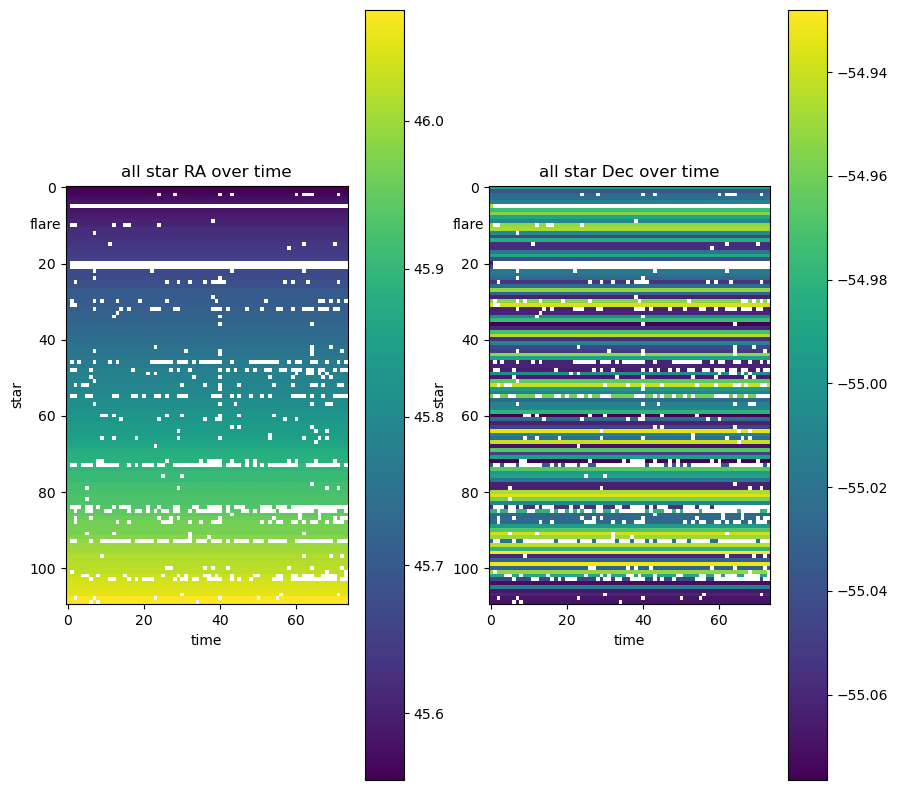

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))
cb = axs[0].imshow(ras.T)
axs[0].set_xlabel("time")
axs[0].set_ylabel("star")
axs[0].set_title("all star RA over time")
axs[0].annotate("flare", (-0.6,11), xytext=(-10, 11), color="k")
plt.colorbar(cb)
cb = axs[1].imshow(decs.T)
axs[1].set_xlabel("time")
axs[1].set_ylabel("star")
axs[1].annotate("flare", (-0.6,11), xytext=(-10, 11), color="k")

plt.colorbar(cb);
axs[1].set_title("all star Dec over time");


In [28]:
raerrs = np.zeros((74, 110)) # error 74 time stamps 110 stars RA uncertainties in deg
decerrs = np.zeros((74, 110)) # error 74 time stamps 110 stars Dec uncertainties in deg
# FBB you could avoid he for loop with the "in" syntax but ok
for j, id in (enumerate(np.sort(main_df['id'].dropna().unique()))): #for every star
    print(f"star id {j}")
    for i, t in (enumerate(main_df['time'].dropna().unique())): #for every time stamp
        if main_df['RA_ERR'][(main_df['id'] == id) * (main_df['time'] == t)].dropna().values:
            raerrs[i,j] = main_df['RA_ERR'][(main_df['id'] == id) * (main_df['time'] == t)].dropna().values 
            decerrs[i,j] = main_df['DEC_ERR'][(main_df['id'] == id) * (main_df['time'] == t)].dropna().values 

        else:
            raerrs[i,j] = np.nan
            decerrs[i,j] = np.nan


star id 0
star id 1
star id 2
star id 3
star id 4
star id 5
star id 6
star id 7
star id 8
star id 9
star id 10
star id 11
star id 12
star id 13
star id 14
star id 15
star id 16
star id 17
star id 18
star id 19
star id 20
star id 21
star id 22
star id 23
star id 24
star id 25
star id 26
star id 27
star id 28
star id 29
star id 30
star id 31
star id 32
star id 33
star id 34
star id 35
star id 36
star id 37
star id 38
star id 39
star id 40
star id 41
star id 42
star id 43
star id 44
star id 45
star id 46
star id 47
star id 48
star id 49
star id 50
star id 51
star id 52
star id 53
star id 54
star id 55
star id 56
star id 57
star id 58
star id 59
star id 60
star id 61
star id 62
star id 63
star id 64
star id 65
star id 66
star id 67
star id 68
star id 69
star id 70
star id 71
star id 72
star id 73
star id 74
star id 75
star id 76
star id 77
star id 78
star id 79
star id 80
star id 81
star id 82
star id 83
star id 84
star id 85
star id 86
star id 87
star id 88
star id 89
star id 90
star id 9

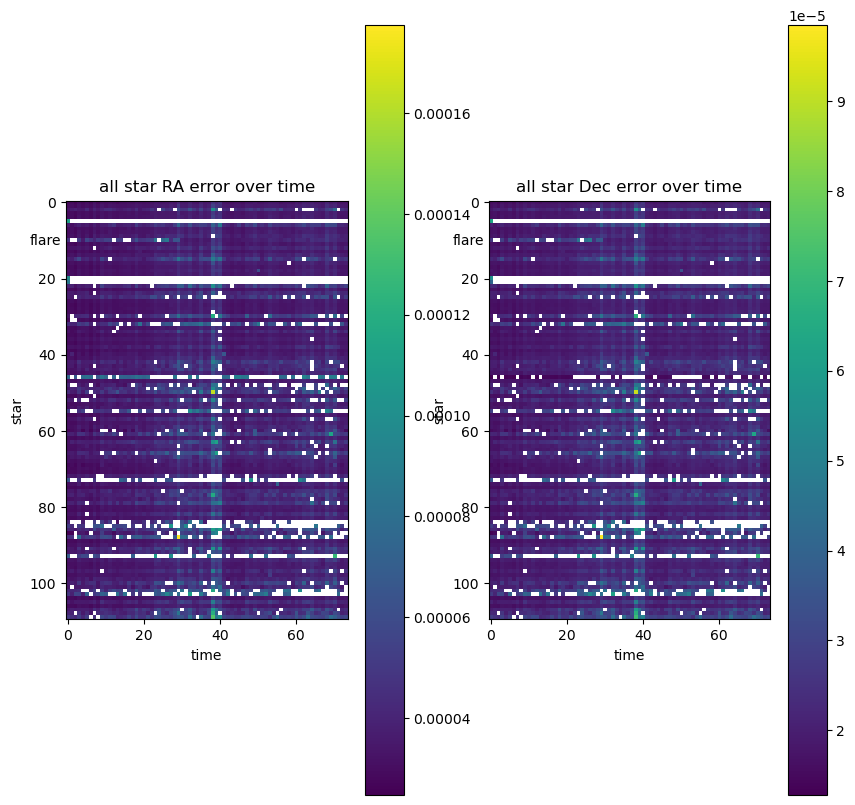

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))
cb = axs[0].imshow(raerrs.T)
axs[0].set_xlabel("time")
axs[0].set_ylabel("star")
axs[0].set_title("all star RA error over time")
axs[0].annotate("flare", (-0.6,11), xytext=(-10, 11), color="k")
plt.colorbar(cb)
cb = axs[1].imshow(decerrs.T)
axs[1].set_xlabel("time")
axs[1].set_ylabel("star")
axs[1].annotate("flare", (-0.6,11), xytext=(-10, 11), color="k")

plt.colorbar(cb);
axs[1].set_title("all star Dec error over time");


In [30]:
# FBB moved here and used throughout instead of repeatedly subtracting the last epoch. Also this is a vectorizable operation! no need for for loop
#FBB convert to arcsec here once and for all isntead of redoing below a bunch of times
shift_ras = (ras - ras[0,:]) * D2ARCSEC# in arcsec
shift_decs = (decs - decs[0,:]) * D2ARCSEC# in arcsec

shift_ras.shape, shift_decs.shape

((74, 110), (74, 110))

In [31]:
# FBB I think you do not need to add the error in quadrature because you just want to have a referende? 
shift_raerrs = raerrs * D2ARCSEC#np.sqrt(raerrs **2 + raerrs[0,:] **2) * D2ARCSEC
shift_decerrs = decerrs * D2ARCSEC#np.sqrt(decerrs**2 +  decerrs[0,:]**2) * D2ARCSEC

shift_raerrs.shape, shift_decerrs.shape

((74, 110), (74, 110))

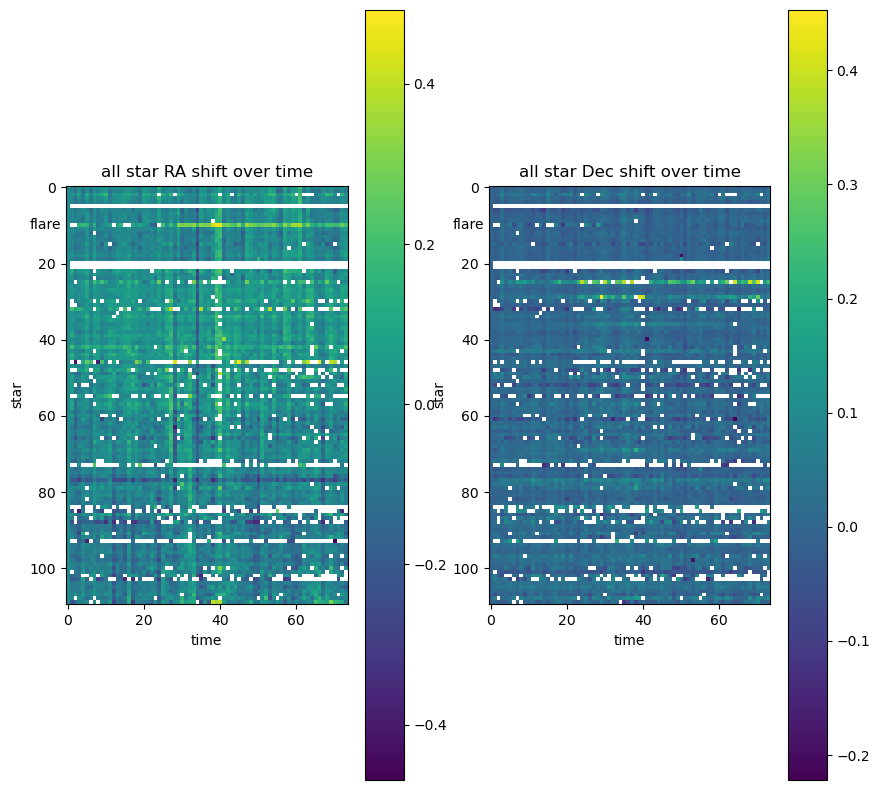

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))
cb = axs[0].imshow(shift_ras.T)
axs[0].set_xlabel("time")
axs[0].set_ylabel("star")
axs[0].set_title("all star RA shift over time")
axs[0].annotate("flare", (-0.6,11), xytext=(-10, 11), color="k")
plt.colorbar(cb)
cb = axs[1].imshow(shift_decs.T)
axs[1].set_xlabel("time")
axs[1].set_ylabel("star")
axs[1].annotate("flare", (-0.6,11), xytext=(-10, 11), color="k")

plt.colorbar(cb);
axs[1].set_title("all star Dec shift over time");


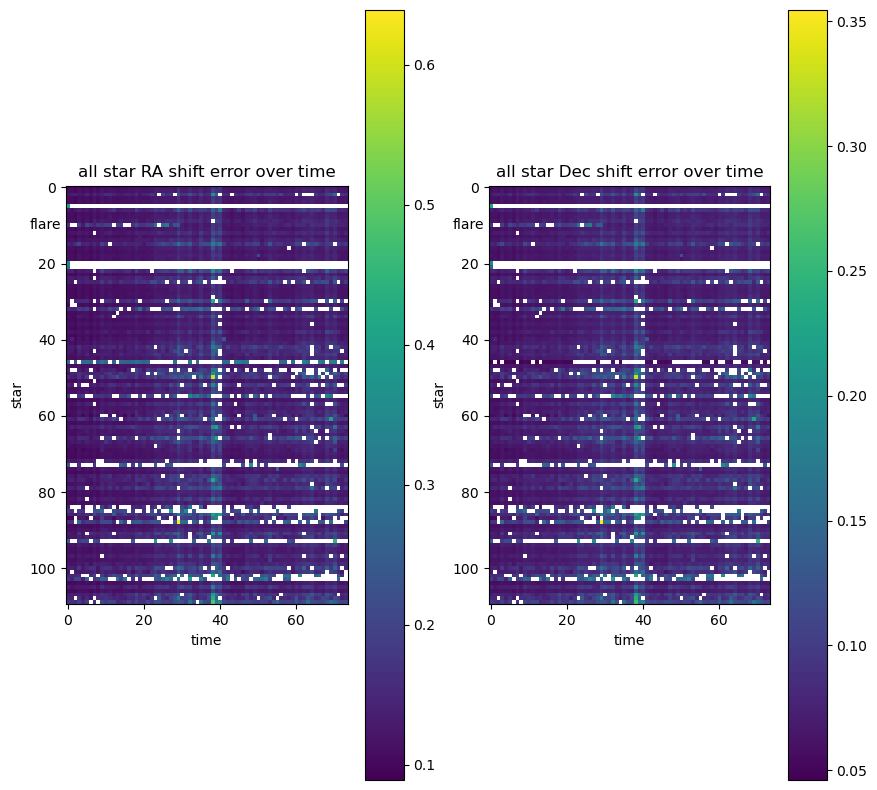

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))
cb = axs[0].imshow(shift_raerrs.T)
axs[0].set_xlabel("time")
axs[0].set_ylabel("star")
axs[0].set_title("all star RA shift error over time")
axs[0].annotate("flare", (-0.6,11), xytext=(-10, 11), color="k")
plt.colorbar(cb)
cb = axs[1].imshow(shift_decerrs.T)
axs[1].set_xlabel("time")
axs[1].set_ylabel("star")
axs[1].annotate("flare", (-0.6,11), xytext=(-10, 11), color="k")

plt.colorbar(cb);
axs[1].set_title("all star Dec shift error over time");


In [34]:
# FBB new array that does not contain flare star
ras_noflare = np.delete(ras, 10, 1)
decs_noflare = np.delete(decs, 10, 1)
ras_noflare.shape, decs_noflare.shape

((74, 109), (74, 109))

In [35]:
# FBB new array that does not contain flare star
shift_ras_noflare = np.delete(shift_ras, 10, 1)
shift_decs_noflare = np.delete(shift_decs, 10, 1)
shift_ras_noflare.shape, shift_decs_noflare.shape

((74, 109), (74, 109))

In [36]:
# FBB new array that does not contain flare star
raerrs_noflare = np.delete(raerrs, 10, 1)
decerrs_noflare = np.delete(decerrs, 10, 1)
raerrs_noflare.shape, decerrs_noflare.shape

((74, 109), (74, 109))

In [37]:
# FBB new array that does not contain flare star
shift_raerrs_noflare = np.delete(shift_ras, 10, 1)
shift_decerrs_noflare = np.delete(shift_decs, 10, 1)
shift_raerrs_noflare.shape, shift_decerrs_noflare.shape

((74, 109), (74, 109))

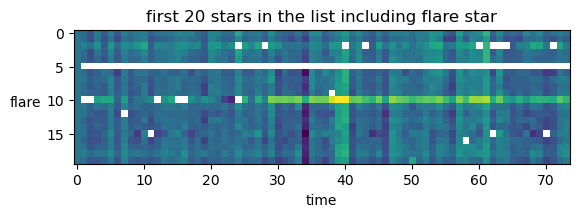

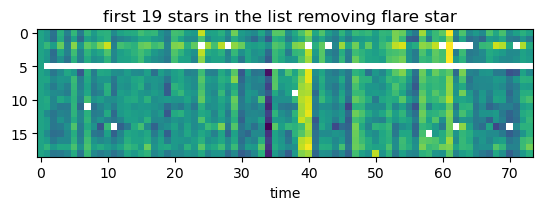

In [38]:
#making sure I removed the flare star: it shows up obviously with a change near epoch 30
plt.imshow(shift_ras[:, :20].T)
plt.xlabel("time")
plt.title("first 20 stars in the list including flare star")
plt.annotate("flare", (1,11), xytext=(-10, 11), color="k")

plt.show()
plt.imshow(shift_ras_noflare[:, :19].T)
plt.title("first 19 stars in the list removing flare star  ")
plt.xlabel("time");


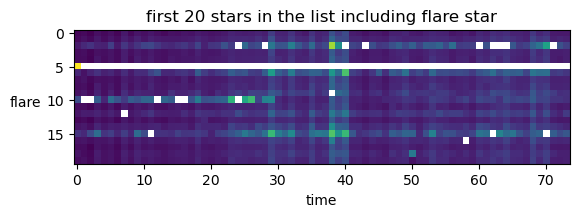

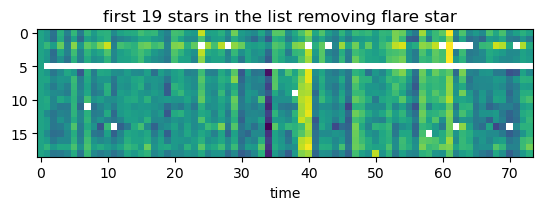

In [39]:
#making sure I removed the flare star: it shows up obviously with a change near epoch 30
plt.imshow(shift_raerrs[:, :20].T)
plt.xlabel("time")
plt.title("first 20 stars in the list including flare star")
plt.annotate("flare", (1,11), xytext=(-10, 11), color="k")

plt.show()
plt.imshow(shift_raerrs_noflare[:, :19].T)
plt.title("first 19 stars in the list removing flare star  ")
plt.xlabel("time");

In [40]:
# FBB make an array for RA of flare and dec of flare only
shift_ras_flare = shift_ras[:,10] 
shift_decs_flare = shift_decs[:,10]
# FBB make an array for RA of flare and dec of flare only
shift_raerrs_flare = shift_raerrs[:,10]
shift_decerrs_flare = shift_decerrs[:,10]
shift_ras_flare.shape, shift_decs_flare.shape, shift_raerrs_flare.shape, shift_decerrs_flare.shape

((74,), (74,), (74,), (74,))

In [41]:
if SAVE:
    np.save('Outdata/ras.npy', ras)
    np.save('Outdata/decs.npy', decs)

    np.save('Outdata/ra_change.npy', shift_ras)
    np.save('Outdata/dec_chane.npy', shift_decs)

In [42]:
select = np.isnan(shift_ras_noflare).sum(axis=0)==0
shift_ras_noflare[:, select].shape

(74, 49)

In [43]:
# FBB use shiftarray instead of subtracting first epoch again
dra_mean = np.nanmean(shift_ras_noflare, axis=1) 
ddec_mean = np.nanmean(shift_decs_noflare, axis=1) 
dra_mean1 = np.mean(shift_ras_noflare[:, select], axis=1) #only stars available in all obs
ddec_mean1 = np.mean(shift_ras_noflare[:, select], axis=1) #only stars available in all obs

dra_std = np.nanstd(shift_ras_noflare, axis=1) 
ddec_std = np.nanstd(shift_decs_noflare, axis=1) 
dra_std1 = np.std(shift_ras_noflare[:, select], axis=1) 
ddec_std1 = np.std(shift_decs_noflare[:, select], axis=1) 
                    

In [44]:
if SAVE:
    np.save('Outdata/raerrs.npy', raerrs)
    np.save('Outdata/decerrs.npy', decerrs)

In [45]:
#standard deviation of each star error overall
raerr_std = np.nanstd(raerrs, axis=1) 
decerr_std = np.nanstd(decerrs, axis=1) 


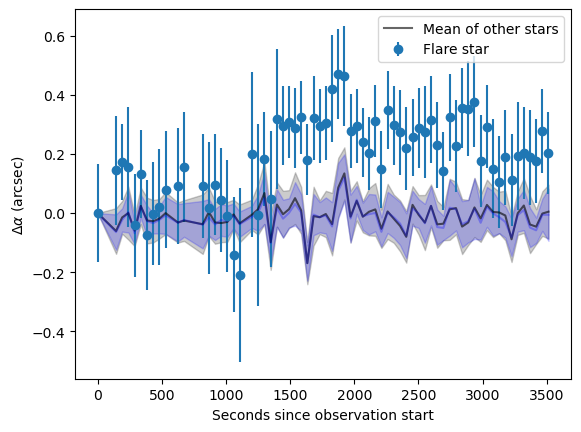

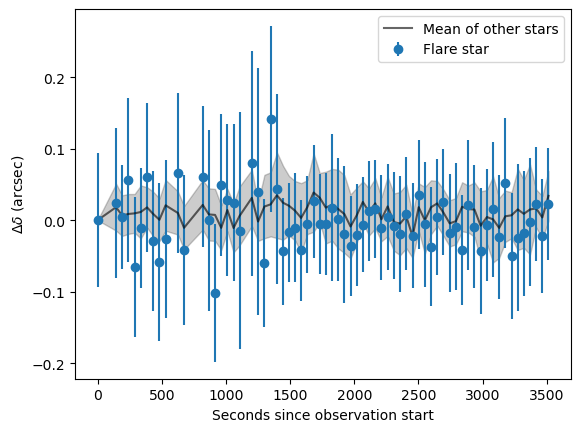

In [46]:
plt.errorbar(dt_sec, shift_ras_flare[t_index], 
             yerr = shift_raerrs_flare[t_index], marker='o', ls='None', label='Flare star')
plt.plot(dt_sec, dra_mean[t_index], c='k', alpha=0.6, label='Mean of other stars')
plt.fill_between(dt_sec, dra_mean[t_index] + dra_std[t_index], dra_mean[t_index] - dra_std[t_index], color='k', alpha=0.2)
plt.ylabel(r'$\Delta\alpha$ (arcsec)')
plt.xlabel('Seconds since observation start')
plt.legend()

plt.plot(dt_sec, dra_mean1[t_index], c='b', alpha=0.3, label='Mean of other stars')
plt.fill_between(dt_sec, dra_mean1[t_index] + dra_std1[t_index], dra_mean1[t_index] - dra_std1[t_index], color='b', alpha=0.2)
plt.show()

plt.errorbar(dt_sec, shift_decs_flare[t_index], 
             yerr = shift_decerrs_flare[t_index], marker='o', ls='None', label='Flare star')
plt.plot(dt_sec, ddec_mean[t_index], c='k', alpha=0.6, label='Mean of other stars')
plt.fill_between(dt_sec, ddec_mean[t_index] + ddec_std[t_index], ddec_mean[t_index] - ddec_std[t_index], color='k', alpha=0.2)
plt.xlabel('Seconds since observation start')
plt.ylabel(r'$\Delta\delta$ (arcsec)')
plt.legend()
plt.show()

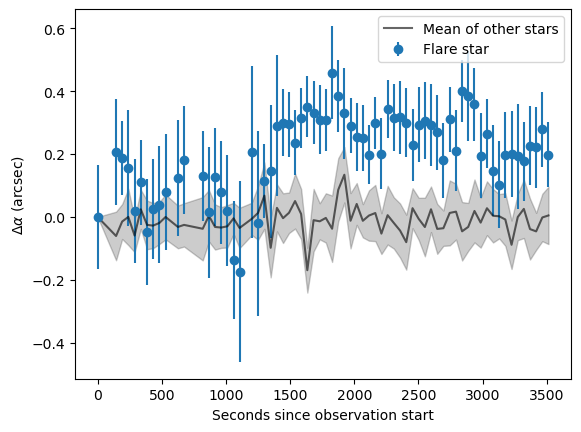

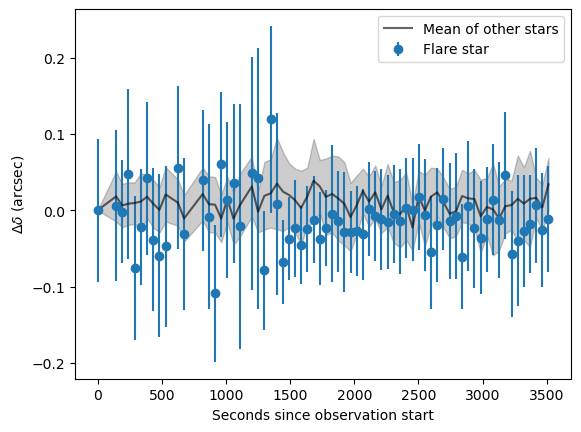

In [47]:
#using only stars with complete coverage at all epochs

plt.errorbar(dt_sec, shift_ras_flare[t_index] - dra_mean[t_index],
             yerr = np.sqrt(shift_raerrs_flare[t_index] **2 - dra_std[t_index] **2) , marker='o', ls='None', label='Flare star')
plt.plot(dt_sec, dra_mean[t_index], c='k', alpha=0.6, label='Mean of other stars')
plt.fill_between(dt_sec, dra_mean[t_index] + dra_std[t_index], dra_mean[t_index] - dra_std[t_index], color='k', alpha=0.2)
plt.ylabel(r'$\Delta\alpha$ (arcsec)')
plt.xlabel('Seconds since observation start')
plt.legend()
plt.show()

plt.errorbar(dt_sec, shift_decs_flare[t_index] - ddec_mean[t_index],
             yerr = np.sqrt(shift_decerrs_flare[t_index] **2 - ddec_std[t_index] **2), marker='o', ls='None', label='Flare star')
plt.plot(dt_sec, ddec_mean[t_index], c='k', alpha=0.6, label='Mean of other stars')
plt.fill_between(dt_sec, ddec_mean[t_index] + ddec_std[t_index], ddec_mean[t_index] - ddec_std[t_index], color='k', alpha=0.2)
plt.xlabel('Seconds since observation start')
plt.ylabel(r'$\Delta\delta$ (arcsec)')
plt.legend()
plt.show()

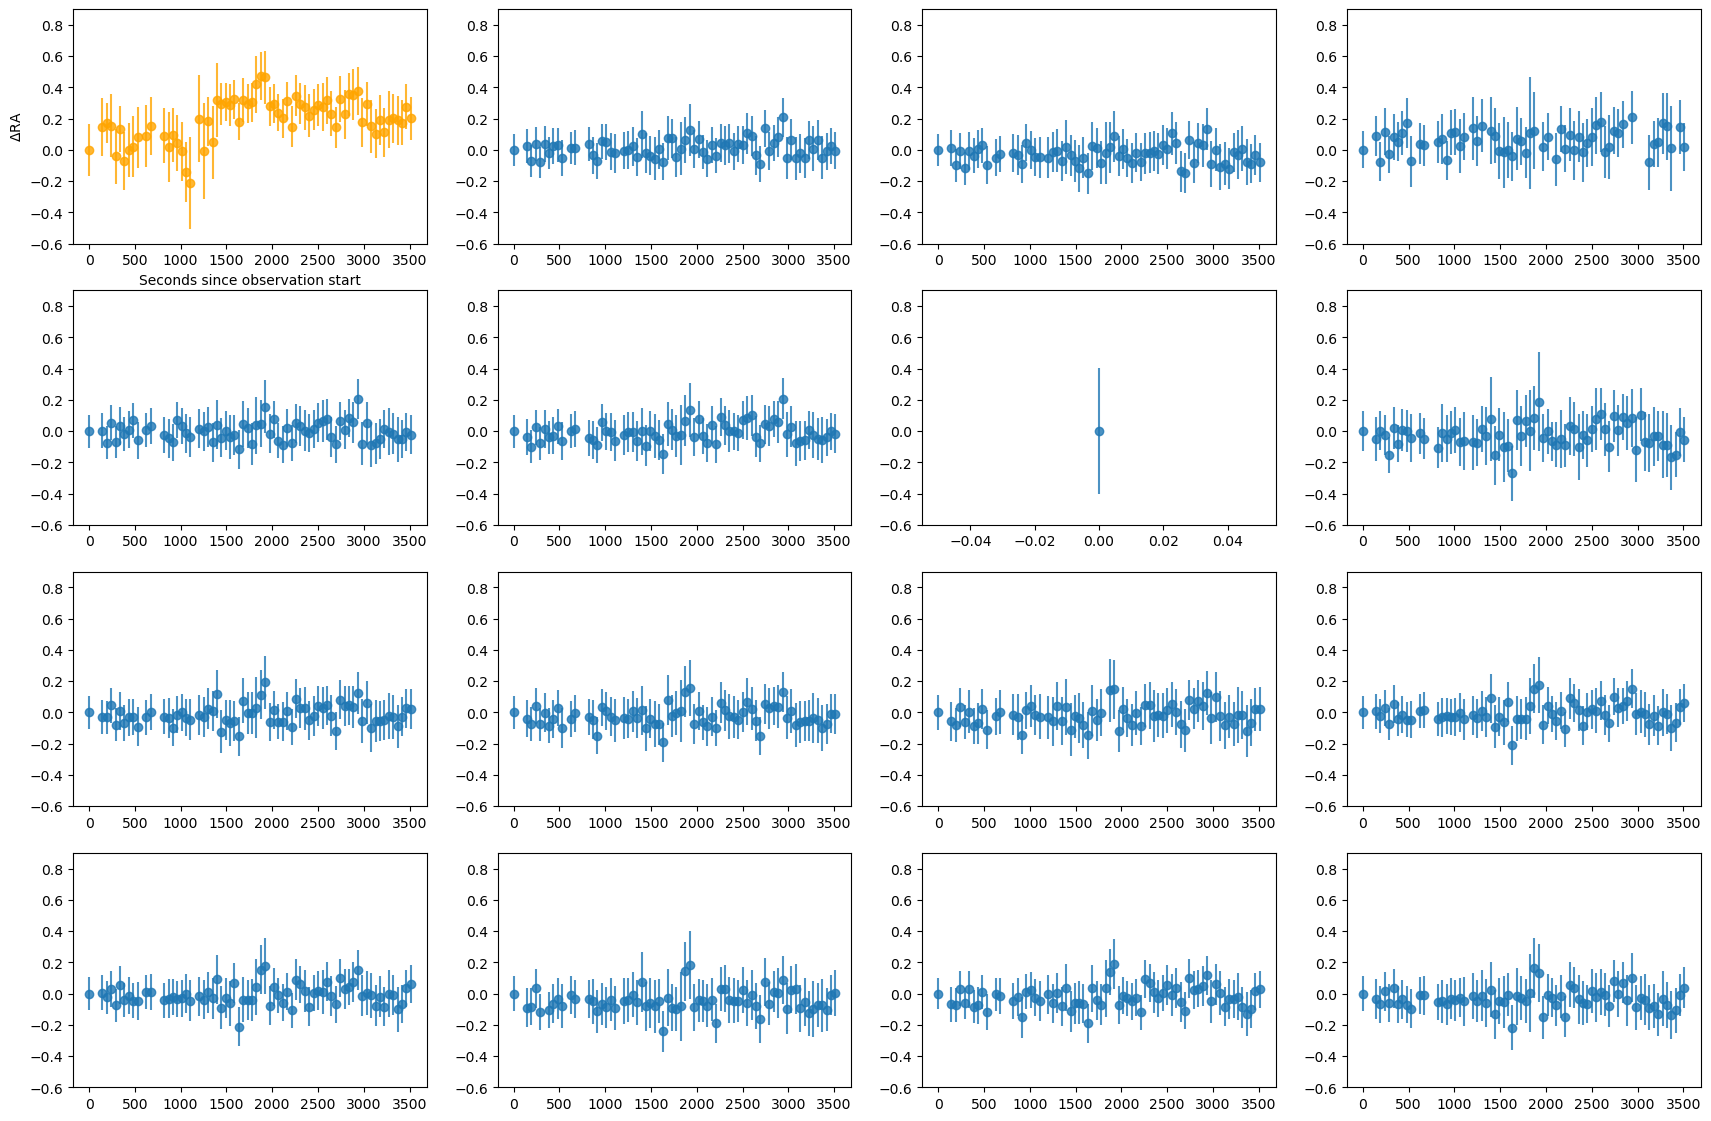

In [48]:
# FBB use shiftarrays which are already relative position and already in arcsec
fig, ax = plt.subplots(4,4, figsize=(21,14))

ax[0][0].errorbar(dt_sec, shift_ras[:,flr_id-1][t_index], yerr=shift_raerrs[:,flr_id-1][t_index], color='orange', ls='None', marker='o', alpha=0.8)

ax[0][0].set_ylim(-0.6,0.9)
ax[0][0].set_xlabel('Seconds since observation start')
ax[0][0].set_ylabel(r'$\Delta$RA')

for i, subax in enumerate(ax.flatten()[1:]):
    if i == flr_id-1:
        i += 1
    subax.errorbar(dt_sec, shift_ras[:,i][t_index], yerr=shift_raerrs[:,i][t_index], ls='None', marker='o', alpha=0.8)
    subax.set_ylim(-0.6,0.9)

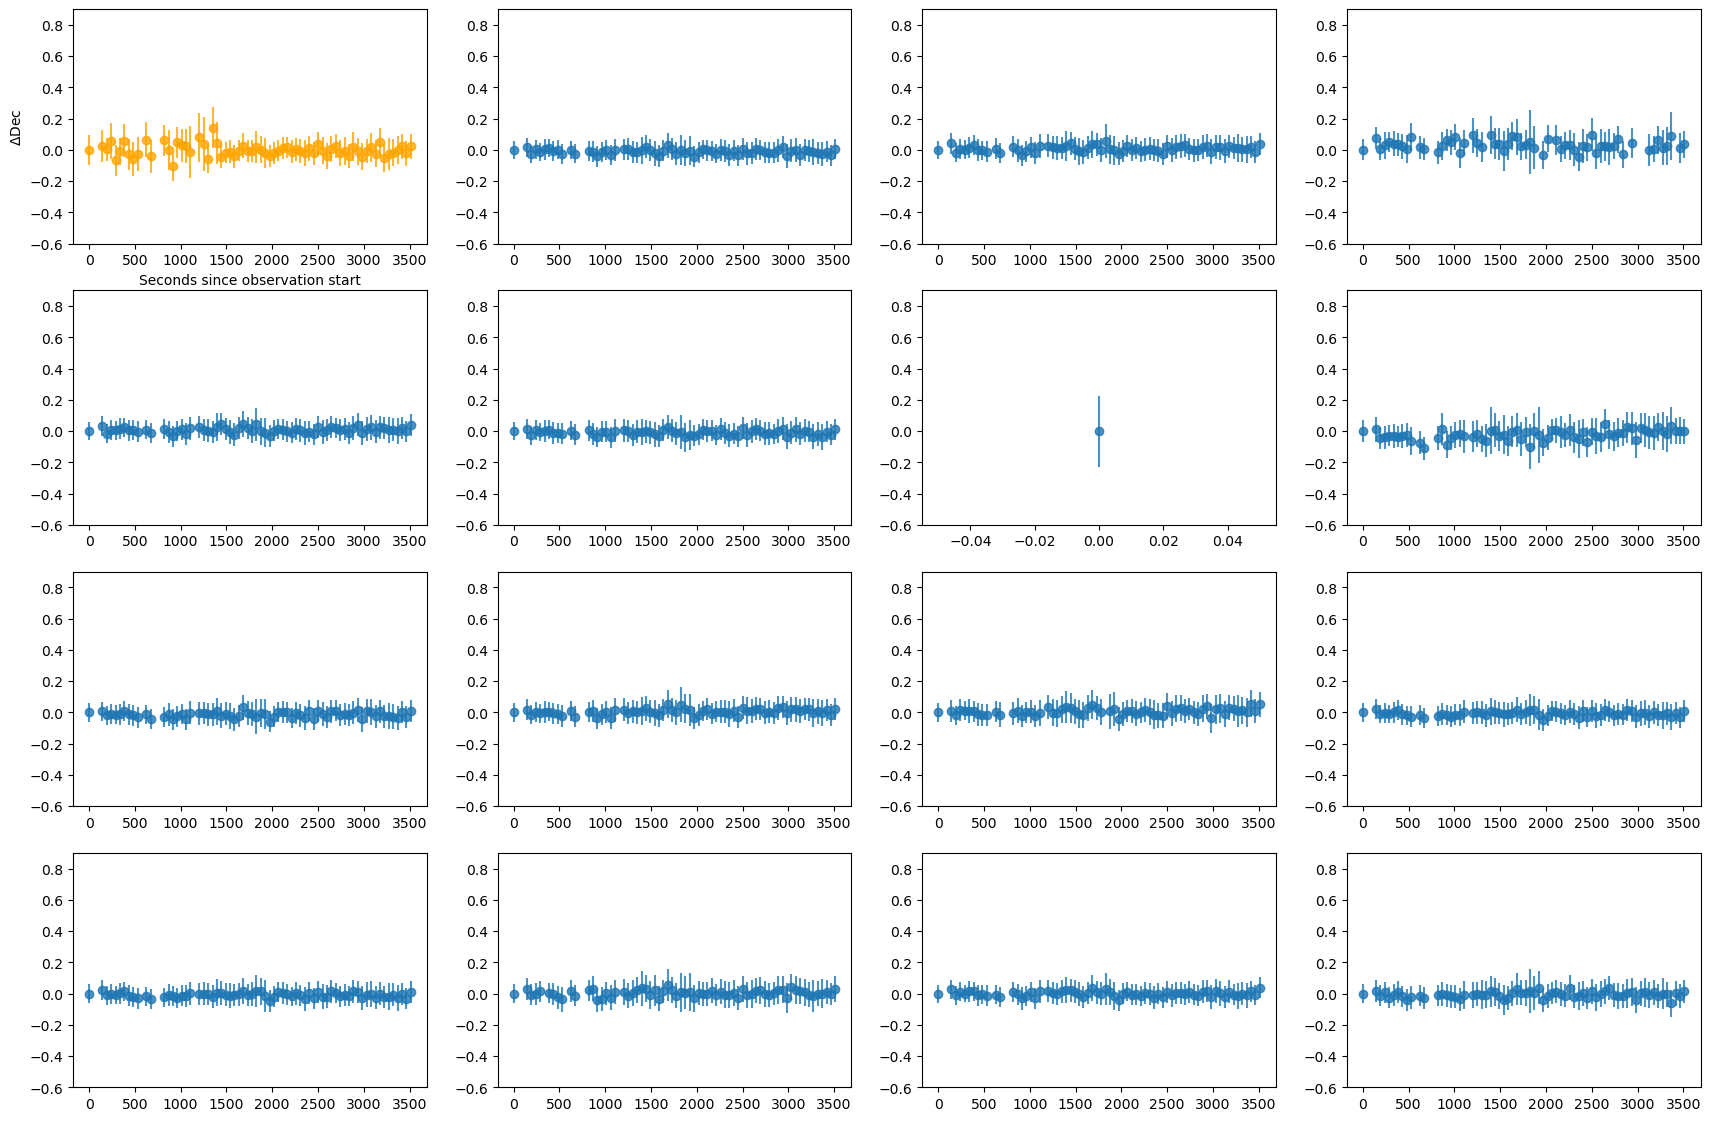

In [49]:
# FBB use shiftarrays which are already relative position and already in arcsec
fig, ax = plt.subplots(4,4, figsize=(21,14))

ax[0][0].errorbar(dt_sec, shift_decs[:,flr_id-1][t_index], yerr=shift_decerrs[:,flr_id-1][t_index], color='orange', ls='None', marker='o', alpha=0.8)

ax[0][0].set_ylim(-0.6,0.9)
ax[0][0].set_xlabel('Seconds since observation start')
ax[0][0].set_ylabel(r'$\Delta$Dec')

for i, subax in enumerate(ax.flatten()[1:]):
    if i == flr_id-1:
        i += 1
    subax.errorbar(dt_sec, shift_decs[:,i][t_index], yerr=shift_decerrs[:,i][t_index], ls='None', marker='o', alpha=0.8)
    subax.set_ylim(-0.6,0.9)

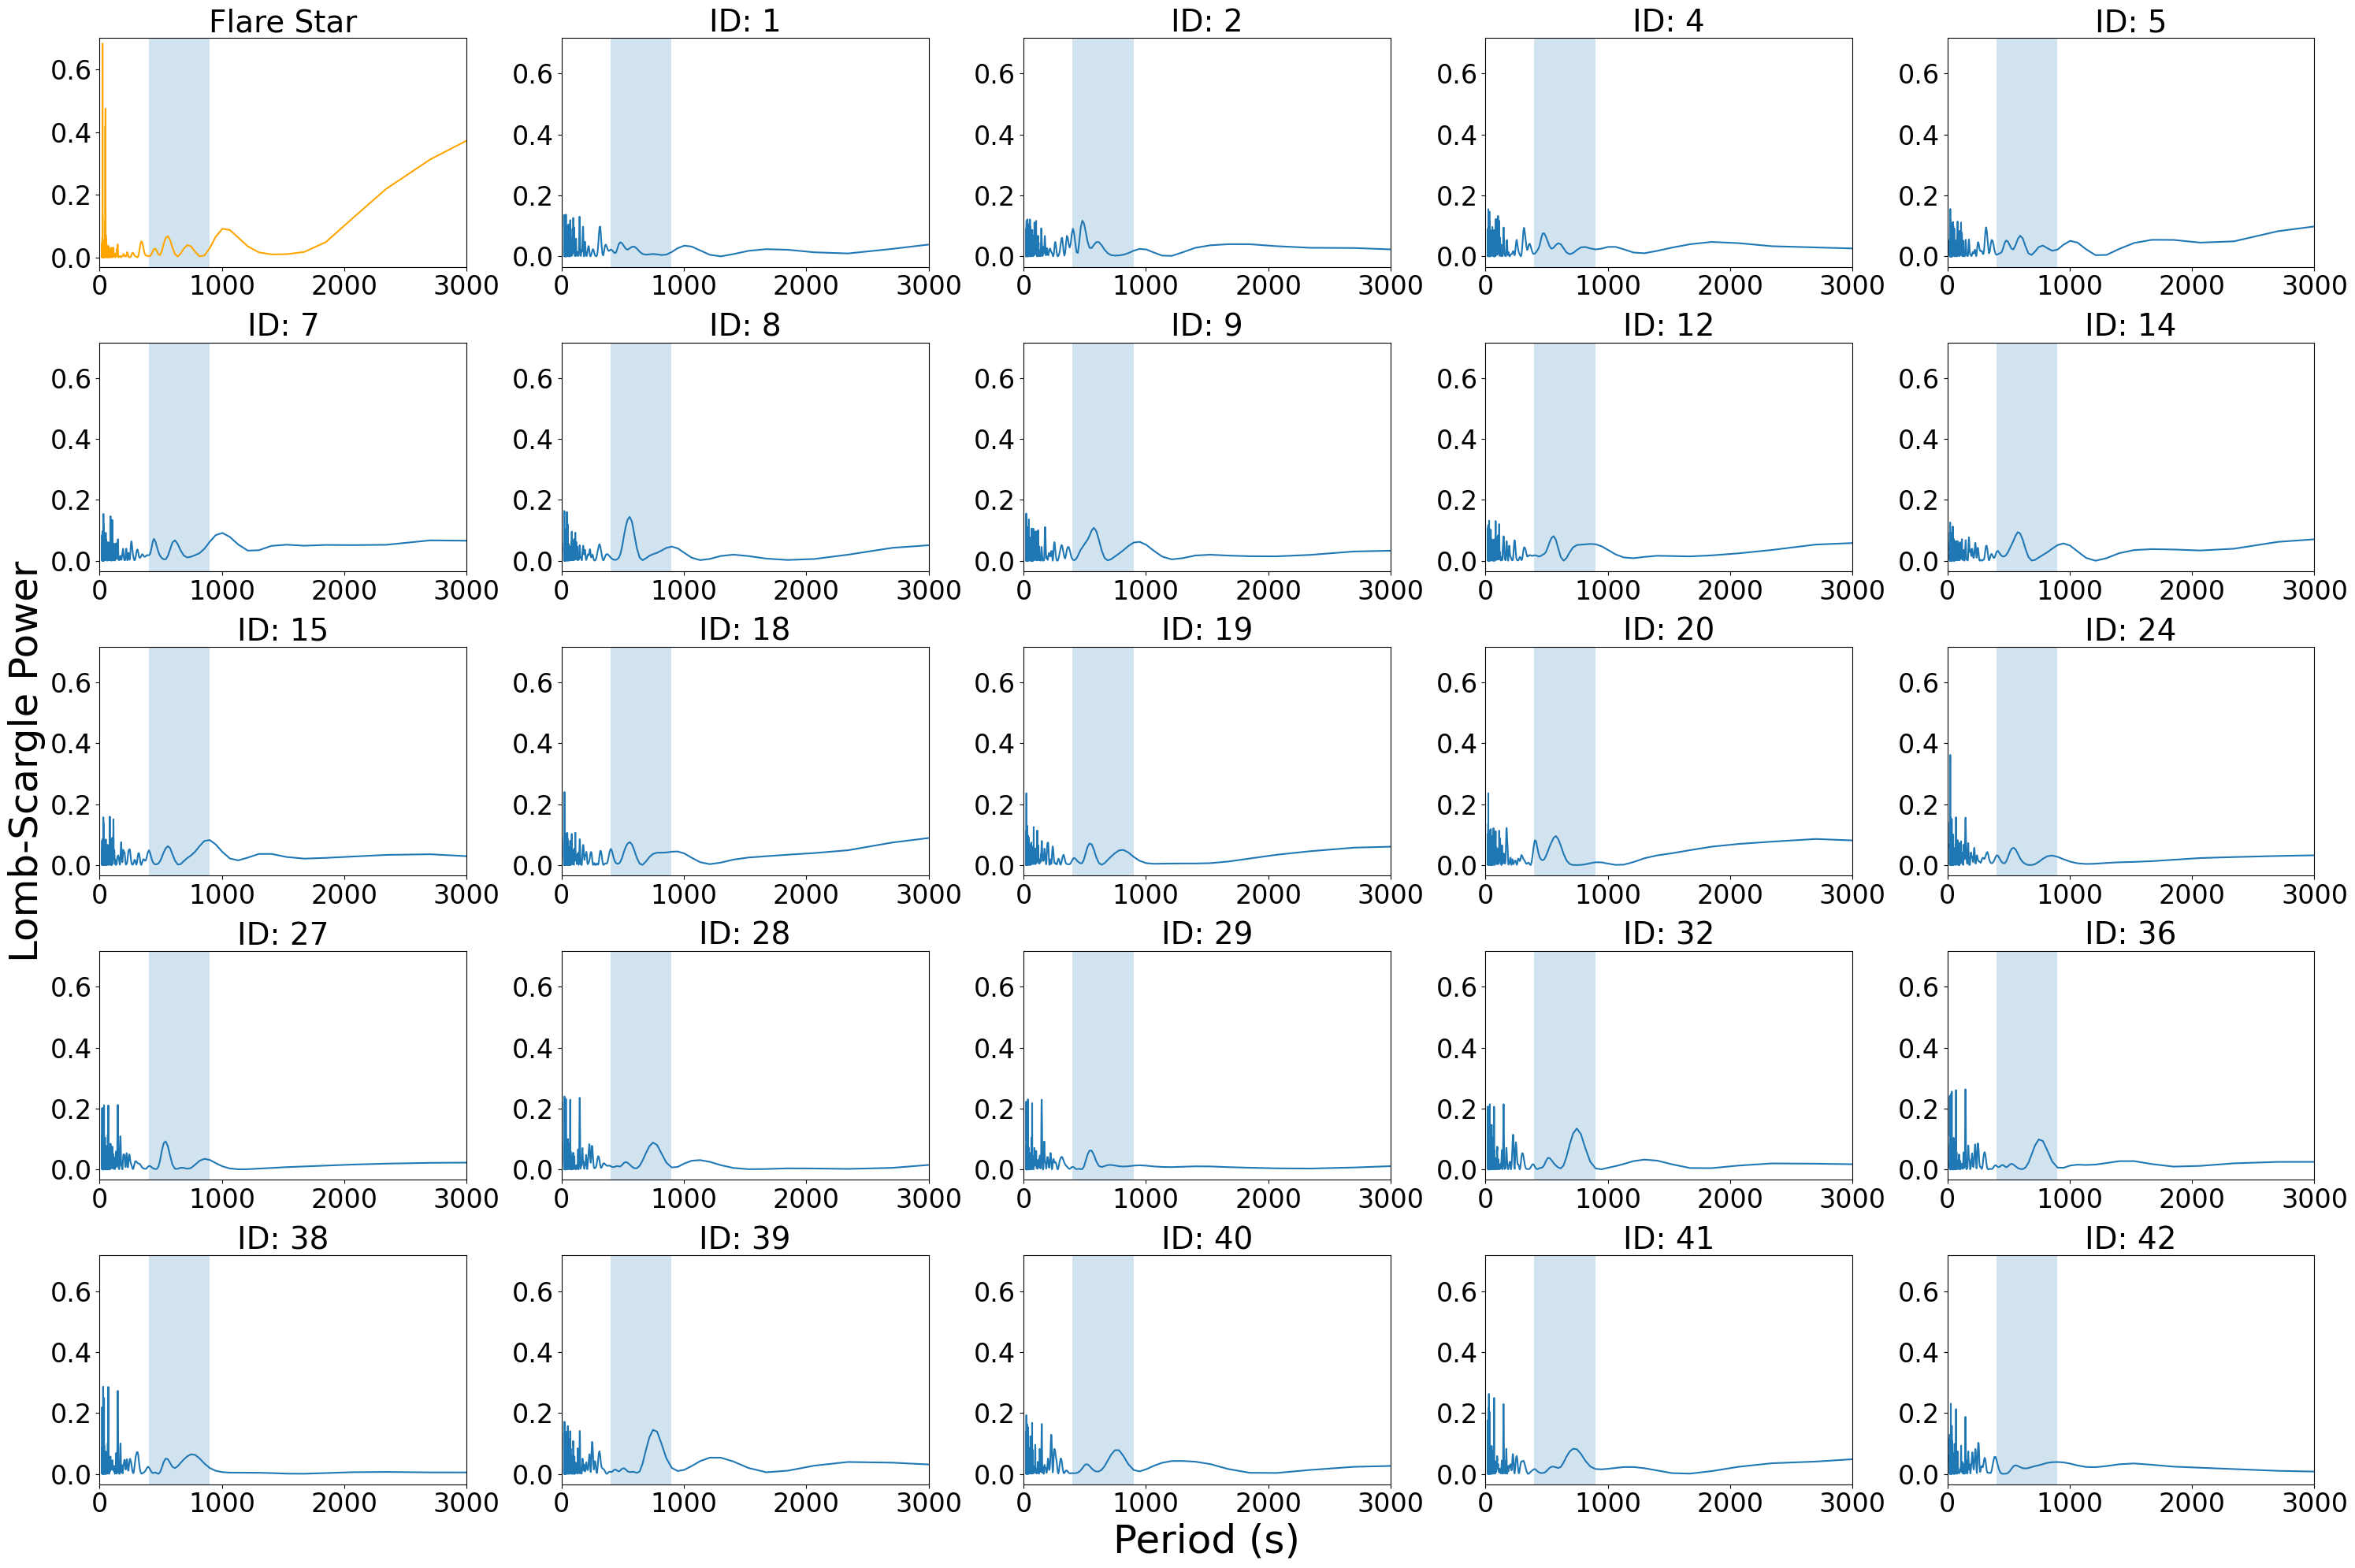

In [50]:
fig, ax = plt.subplots(5,5, figsize=(30,20))

freq, pow = LombScargle(dt_sec, shift_ras[:,flr_id-1][t_index], shift_raerrs[:,flr_id-1][t_index]).autopower()

ax.flatten()[0].plot(1/freq,pow, c='orange')
ax.flatten()[0].set_xlim(0,3000)

c = 0

for i in range(1,len(ax.flatten())):

    freq, pow = LombScargle(dt_sec, shift_ras[:,c][t_index], shift_raerrs[:,c][t_index]).autopower()

    while (np.isnan(pow)).any():
        c += 1
        if c == flr_id - 1:
            c += 1
        freq, pow = LombScargle(dt_sec, shift_ras[:,c][t_index], shift_raerrs[:,c][t_index]).autopower()

    ax.flatten()[i].plot(1/freq, pow)
    ax.flatten()[i].set_xlim(0,3000)
    ax.flatten()[i].set_ylim(ax.flatten()[0].get_ylim())

    if i == 22:
        ax.flatten()[i].set_xlabel('Period (s)', fontsize=36)
    if i == 10:
        ax.flatten()[i].set_ylabel('Lomb-Scargle Power', fontsize=36)

    ax.flatten()[i].set_title('ID: {}'.format(c+1), fontsize=28)
    c += 1

for a in ax.flatten():
    a.tick_params(axis='both', labelsize=24)
    a.fill_betweenx(y = [a.get_ylim()[0], a.get_ylim()[1]], x1=400, x2=900, alpha=0.2)

ax.flatten()[0].set_ylim(-0.03, 0.7)
ax.flatten()[0].set_title('Flare Star', fontsize=28)

fig.tight_layout()

plt.savefig('Figures/dparffts.png', dpi=300, bbox_inches='tight')

## Converting $\alpha, \delta$ to $d_{\parallel}$

In [51]:
shift_ras.shape, shift_decs.shape, times.shape

((74, 110), (74, 110), (74,))

In [52]:
#Concat flare arrays to top 
'''
flr_ras = np.zeros_like(ras[:,0])
flr_decs = np.zeros_like(decs[:,0])
flr_raerrs = np.zeros_like(ras[:,0])
flr_decerrs = np.zeros_like(decs[:,0])

c = 0

for i, t in enumerate(times):
    
    if t_index[i]:

        flr_ras[i] = main_df['RA'][main_df['id'] == flr_id].iloc[c]
        flr_decs[i] = main_df['DEC'][main_df['id'] == flr_id].iloc[c]
        flr_raerrs[i] = main_df['RA_ERR'][main_df['id'] == flr_id].iloc[c]
        flr_decerrs[i] = main_df['DEC_ERR'][main_df['id'] == flr_id].iloc[c]
        c += 1
    else:

        flr_ras[i] = np.nan
        flr_decs[i] = np.nan
        flr_raerrs[i] = np.nan
        flr_decerrs[i] = np.nan

ras = np.concatenate((flr_ras[:,np.newaxis], ras), axis=1)
decs = np.concatenate((flr_decs[:,np.newaxis], decs), axis=1)
raerrs = np.concatenate((flr_raerrs[:,np.newaxis], raerrs), axis=1)
decerrs = np.concatenate((flr_decerrs[:,np.newaxis], decerrs), axis=1)
'''

"\nflr_ras = np.zeros_like(ras[:,0])\nflr_decs = np.zeros_like(decs[:,0])\nflr_raerrs = np.zeros_like(ras[:,0])\nflr_decerrs = np.zeros_like(decs[:,0])\n\nc = 0\n\nfor i, t in enumerate(times):\n    \n    if t_index[i]:\n\n        flr_ras[i] = main_df['RA'][main_df['id'] == flr_id].iloc[c]\n        flr_decs[i] = main_df['DEC'][main_df['id'] == flr_id].iloc[c]\n        flr_raerrs[i] = main_df['RA_ERR'][main_df['id'] == flr_id].iloc[c]\n        flr_decerrs[i] = main_df['DEC_ERR'][main_df['id'] == flr_id].iloc[c]\n        c += 1\n    else:\n\n        flr_ras[i] = np.nan\n        flr_decs[i] = np.nan\n        flr_raerrs[i] = np.nan\n        flr_decerrs[i] = np.nan\n\nras = np.concatenate((flr_ras[:,np.newaxis], ras), axis=1)\ndecs = np.concatenate((flr_decs[:,np.newaxis], decs), axis=1)\nraerrs = np.concatenate((flr_raerrs[:,np.newaxis], raerrs), axis=1)\ndecerrs = np.concatenate((flr_decerrs[:,np.newaxis], decerrs), axis=1)\n"

In [53]:
pa_arr = np.zeros_like(ras)
delpa_arr = np.zeros_like(ras)

for i in range(ras.shape[0]):
    for j in range(ras.shape[1]):
        pa_arr[i][j], delpa_arr[i][j] = celest_to_pa(ras[i,j], decs[i,j], delra = raerrs[i][j], deldec = decerrs[i][j],
                                                     time = Time(times[i], format='mjd'), loc = EarthLocation.of_site('Cerro Tololo'))

pa_arr_noflare = np.delete(pa_arr, 10, 1)
delpa_arr_noflare = np.delete(delpa_arr, 10, 1)
pa_arr.shape, delpa_arr.shape, pa_arr_noflare.shape, delpa_arr_noflare.shape

((74, 110), (74, 110), (74, 109), (74, 109))

In [54]:
dpar_arr = np.zeros_like(ras)
deldpar_arr = np.zeros_like(ras)
ddra_arr = np.zeros_like(ras)
dddec_arr = np.zeros_like(ras)
ddpar_arr = np.zeros_like(ras)


for t in range(shift_ras.shape[0]): #time
    for s in range(shift_ras.shape[1]): #star
            dpar_arr[t][s], deldpar_arr[t][s], ddra_arr[t][s], dddec_arr[t][s], ddpar_arr[t][s] = dpar(shift_ras[t,s] / 3600, shift_decs[t,s] / 3600, pa_arr[t,s], 
                                  delra = np.sqrt(raerrs[t,s]**2 + raerrs[0,s]**2), deldec = np.sqrt(decerrs[t,s]**2 + decerrs[0,s]**2), delpa2=delpa_arr[t,s])

dpar_arr[0,:] = 0.0
deldpar_arr[0,:] = 0.0

dpar_arr_noflare = np.delete(dpar_arr, 10, 1)
deldpar_arr_noflare = np.delete(deldpar_arr, 10, 1)
dpar_arr.shape, deldpar_arr.shape, dpar_arr_noflare.shape, deldpar_arr_noflare.shape
np.save('Outdata/dpar_arr.npy', dpar_arr)

In [55]:
proj_angles = np.rad2deg((np.pi * 0.5) - np.deg2rad(pa_arr) - np.arctan2(shift_decs, shift_ras))
proj_angles_noflare = np.delete(proj_angles, 10, 1)
proj_angles.shape, proj_angles_noflare.shape

((74, 110), (74, 109))

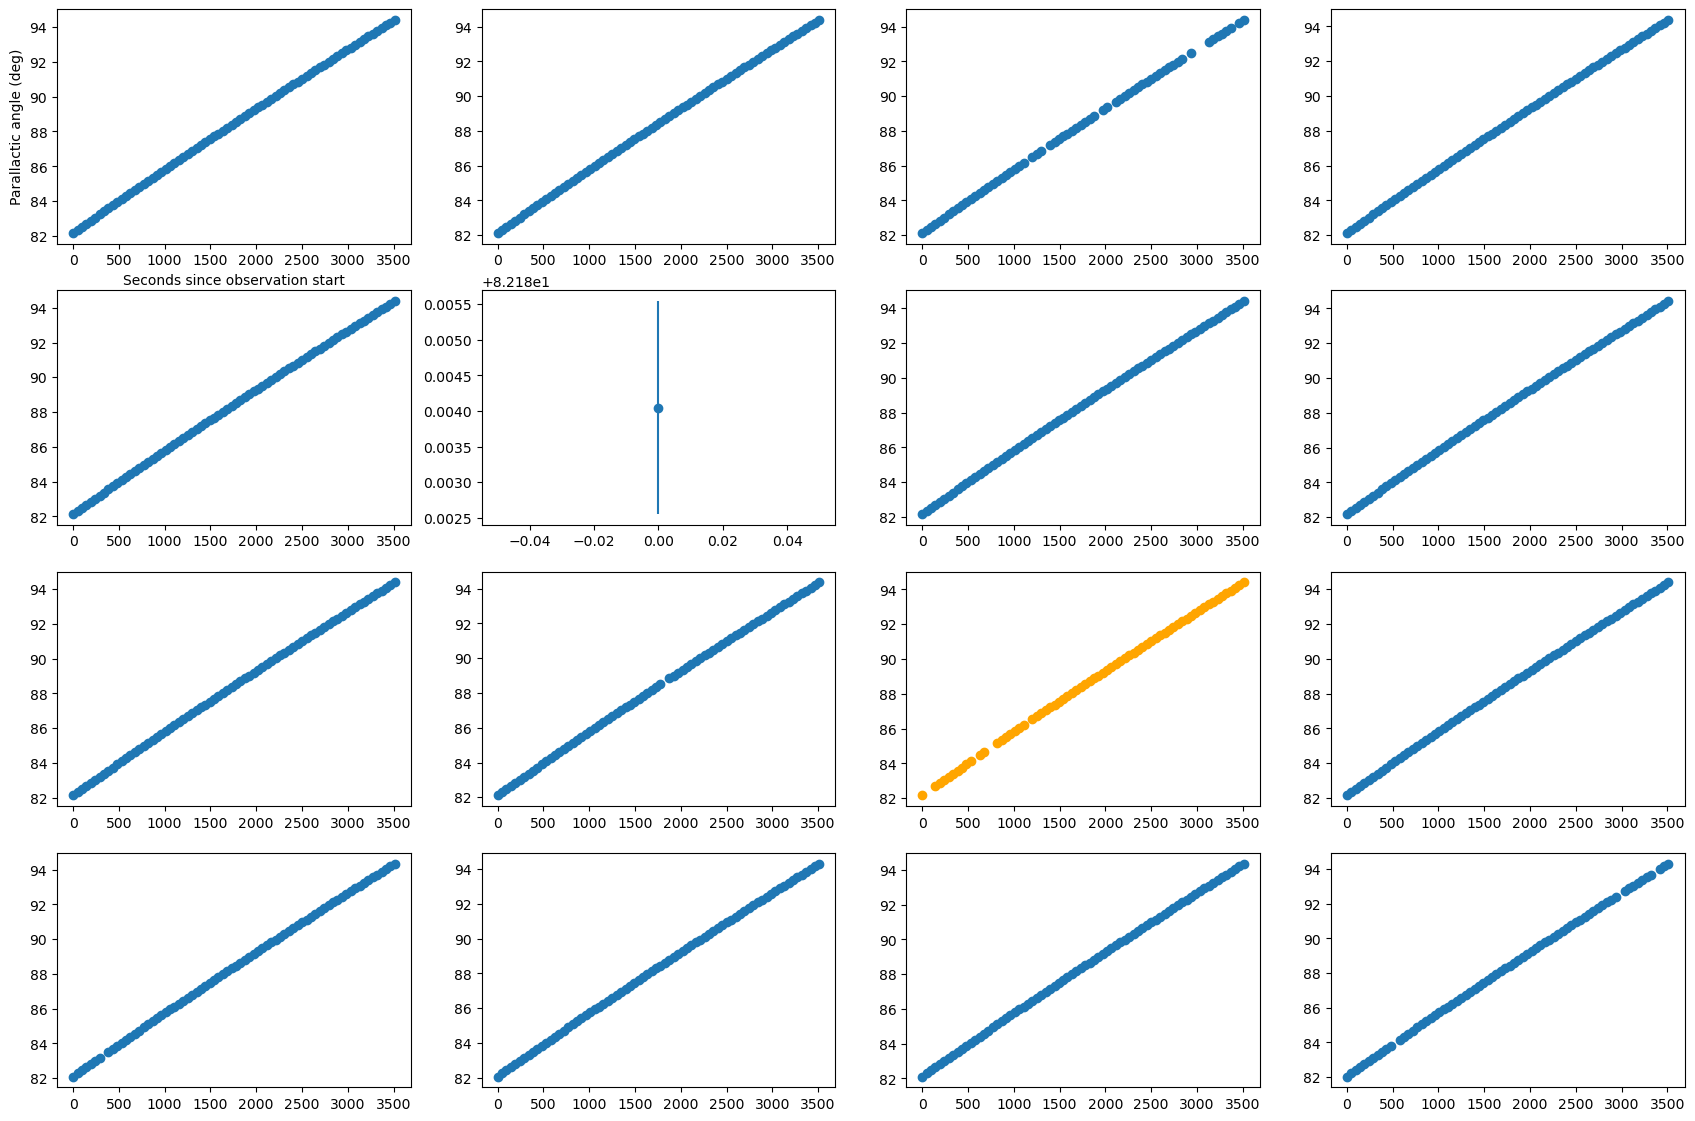

In [56]:
fig, ax = plt.subplots(4,4, figsize=(21,14))

for i in range(len(ax.flatten())):

    if i == flr_id - 1:
        ax.flatten()[i].errorbar(tSec, pa_arr[:,i], yerr = delpa_arr[:,i], color='orange', marker='o', ls='None')

    else:
        ax.flatten()[i].errorbar(tSec, pa_arr[:,i], yerr = delpa_arr[:,i], marker='o', ls='None')

ax[0][0].set_xlabel('Seconds since observation start')
ax[0][0].set_ylabel('Parallactic angle (deg)');

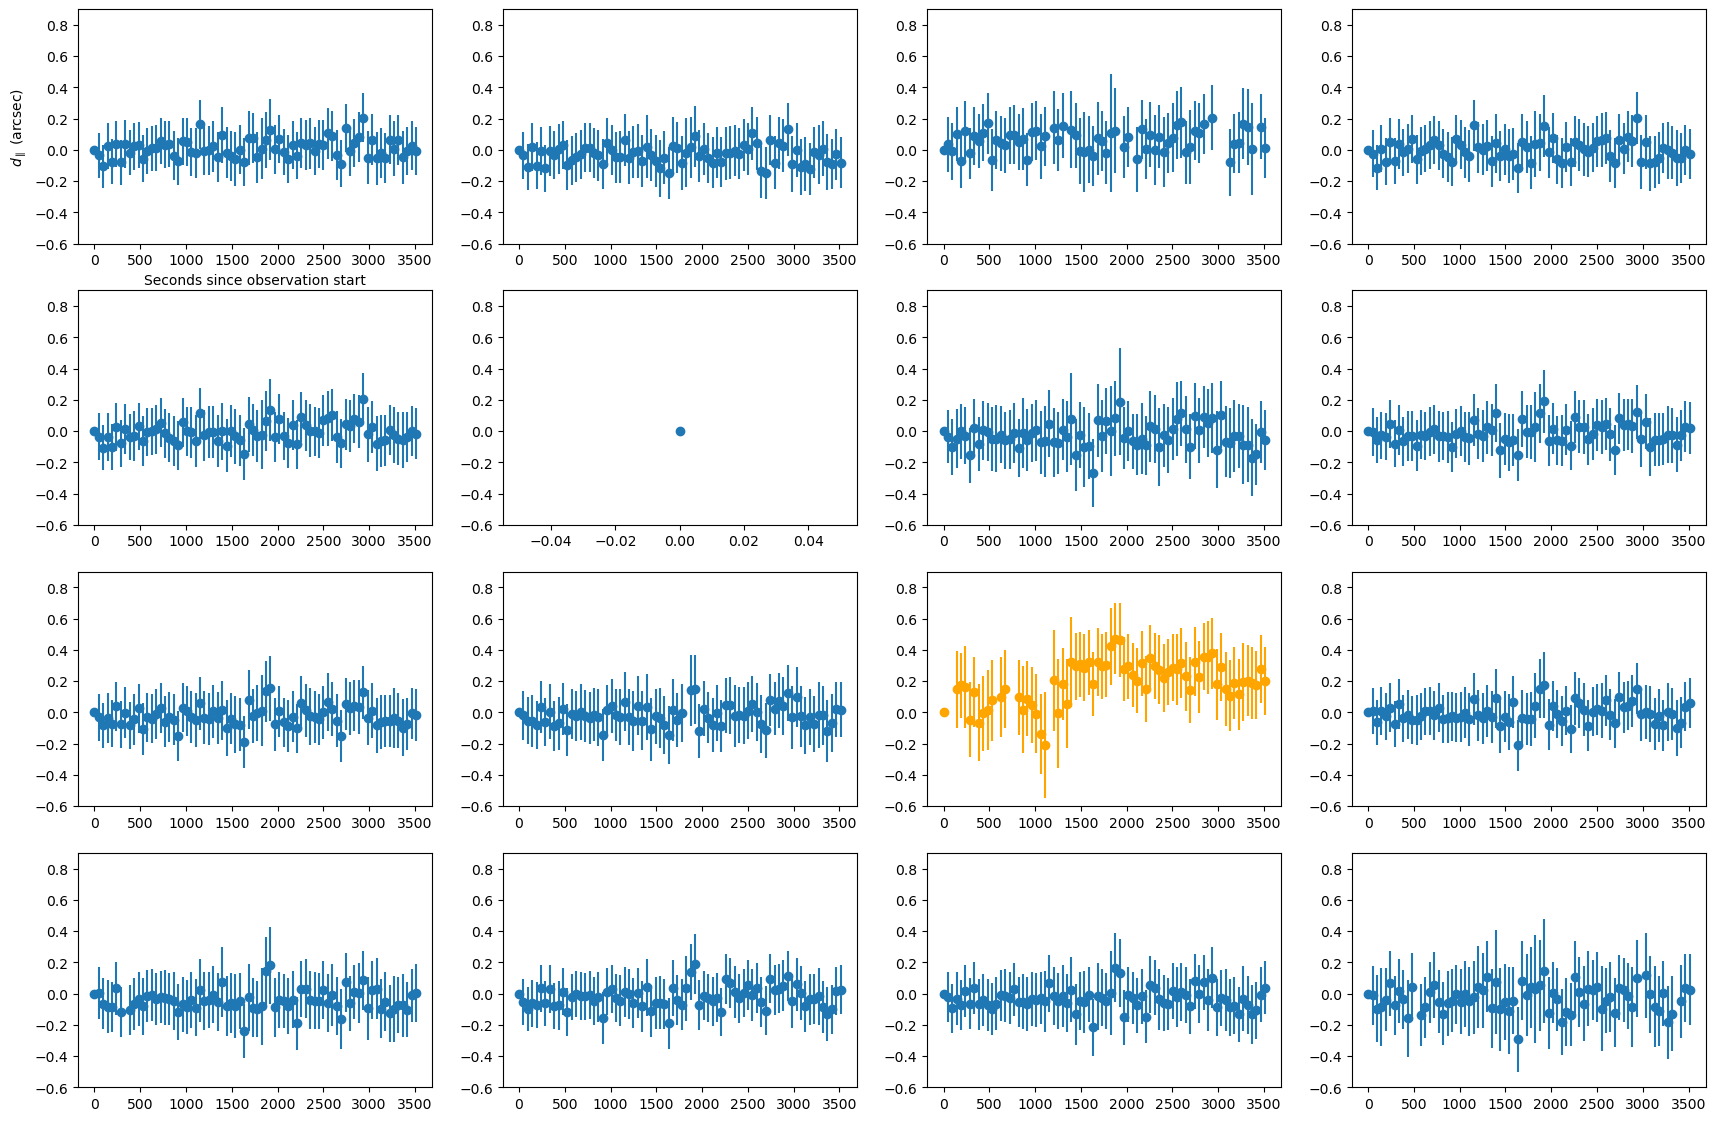

In [57]:
fig, ax = plt.subplots(4,4, figsize=(21,14))

for i in range(len(ax.flatten())):

    if i == flr_id-1:
        ax.flatten()[i].errorbar(tSec, dpar_arr[:,flr_id-1] * D2ARCSEC, yerr = deldpar_arr[:,flr_id-1] * D2ARCSEC, color='orange', marker='o', ls='None')
        ax.flatten()[i].set_ylim(-0.6,0.9)
    else:
        ax.flatten()[i].errorbar(tSec, dpar_arr[:,i] * D2ARCSEC, yerr = deldpar_arr[:,i] * D2ARCSEC, marker='o', ls='None')
        ax.flatten()[i].set_ylim(-0.6,0.9)

ax[0][0].set_xlabel('Seconds since observation start')
ax[0][0].set_ylabel(r'$d_{\parallel}$ (arcsec)');

### Converting $d_{\parallel}$ to $T_{eff}$

### Conditioning the $d_{\parallel}$ data

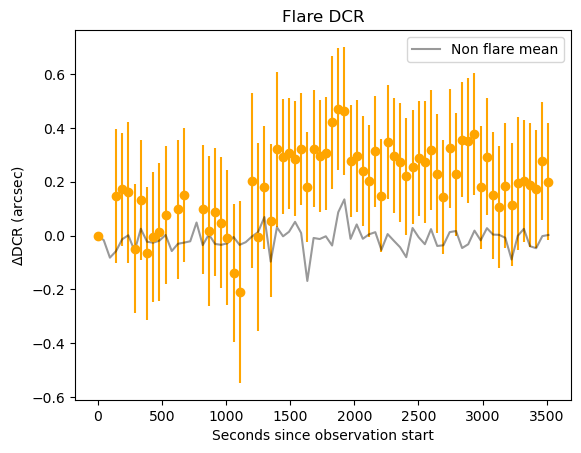

In [58]:
# FBB IMPORTANT! remove the flaring star from the average!!!
fig, ax = plt.subplots()
ax.errorbar(tSec, dpar_arr[:,flr_id-1] * D2ARCSEC, yerr = deldpar_arr[:,flr_id-1] * D2ARCSEC, color='orange', marker='o', ls='None')
ax.plot(tSec, np.nanmean(dpar_arr_noflare, axis=1) * D2ARCSEC, c='k', alpha=0.4, label='Non flare mean')
ax.set_xlabel('Seconds since observation start')
ax.set_ylabel(r'$\Delta$DCR (arcsec)')
ax.set_title('Flare DCR')
ax.legend()

plt.savefig('Figures/raw_dpar.png', dpi = 300, bbox_inches='tight')

In [59]:
fullstars = ((dpar_arr_noflare.shape[1] - np.isnan(dpar_arr_noflare).sum(axis=0)) == 109)

print(f"number of stars detected in all frames {((dpar_arr_noflare.shape[1] - np.isnan(dpar_arr_noflare).sum(axis=0)) == 109).sum()}")
dpar_arr_noflare_alldetected = dpar_arr_noflare[:,fullstars]

number of stars detected in all frames 49


In [60]:
dpar_ma = np.ma.MaskedArray(dpar_arr_noflare, mask=np.isnan(dpar_arr_noflare))
dparerr_ma = dpar_ma.std(axis=1)
dparerr_ma = dparerr_ma.data.reshape((1,74))
dparerr_ma.shape, dpar_ma.shape

((1, 74), (74, 109))

In [79]:
dpdiff = np.load(ROOTDIR + "DCRsum_m7.npy") #adding expected collective dDCR shift for average (solar) star
dpdiff

array([ 0.        ,  0.24674275,  0.4933687 ,  0.74130463,  0.98799859,
        1.23797912,  1.49507914,  1.7485091 ,  2.00758291,  2.25664321,
        2.52106227,  2.77818975,  3.03802498,  3.29718333,  3.55785723,
        3.82180199,  4.09153374,  4.35732295,  4.62405531,  4.89272675,
        5.16204619,  5.43254559,  5.70407088,  5.97061913,  6.2454311 ,
        6.51786243,  6.79891602,  7.08592127,  7.37035826,  7.65635559,
        7.93654234,  8.21201349,  8.49189845,  8.77469518,  9.06435714,
        9.35945011,  9.64902801,  9.93826598, 10.23927753, 10.53338813,
       10.82875535, 11.12799362, 11.42843118, 11.72924167, 12.03178855,
       12.34439716, 12.64861285, 12.95933728, 13.26960892, 13.58635397,
       13.90114476, 14.22238394, 14.53799471, 14.85658823, 15.17474066,
       15.49997307, 15.82296956, 16.15521992, 16.48941597, 16.81478238,
       17.14171622, 17.47947657, 17.81410467, 18.15713172, 18.49257694,
       18.82781072, 19.16836134, 19.51504159, 19.86276206, 20.20

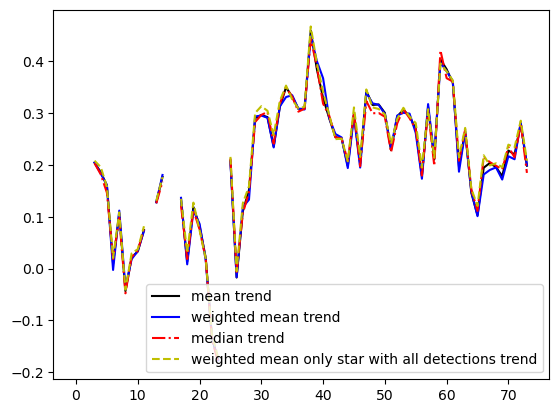

In [80]:
dpar_raw = dpar_arr[:,flr_id-1] * D2ARCSEC
dpar_trend_1 = np.nanmean(dpar_arr_noflare, axis=1) * D2ARCSEC
fig = plt.figure()
plt.plot(dpar_raw - dpar_trend_1, 'k', label="mean trend")

dparerr_ma = dpar_ma.std(axis=1)

dpar_trend_2 = np.average(dpar_ma, axis=1, weights=np.nanstd(dpar_arr_noflare, axis=0), ) * D2ARCSEC
plt.plot(dpar_raw - dpar_trend_2, 'b', label="weighted mean trend")

dpar_trend_3 = np.nanmedian(dpar_arr_noflare, axis=1) * D2ARCSEC
plt.plot(dpar_raw - dpar_trend_3, 'r-.', label="median trend")

dpar_trend_4 = np.average(dpar_arr_noflare_alldetected, axis=1, weights=dpar_arr_noflare_alldetected.std(axis=0)) * D2ARCSEC
plt.plot(dpar_raw - dpar_trend_4, 'y--',
                       label="weighted mean only star with all detections trend")

plt.legend()
dpar_subtracted = dpar_raw - dpar_trend_4 #+ dpdiff
dparerr = deldpar_arr[:,flr_id-1] * D2ARCSEC
dparerr[0] = np.nan
dparerr_subtracted = np.sqrt(dparerr**2 + np.nanstd(dpar_arr_noflare, axis=1)**2)
window = 10
_ = pd.Series(dpar_subtracted).rolling(window, min_periods=1, center=True)
dpar_smoothed = _.median()
dpar_count = _.apply(lambda l: np.sum(~np.isnan(l)))
dparerr_smoothed = pd.Series(dparerr).rolling(window, min_periods=1, center=True).apply(lambda l: np.sqrt(np.nansum(l**2))) / dpar_count
dparerr_smoothed = pd.Series(dparerr).rolling(window, min_periods=1, center=True).apply(lambda l: np.sqrt(np.nansum(l**2))) / dpar_count

dpar_smoothedmean = _.mean()


flare_df = pd.DataFrame.from_dict({"mjd":times,
                                   "time": tSec,
                                        "dpar_raw": dpar_raw, 
                                        "dpar_error": dparerr,
                                        "dpar_detrended": dpar_subtracted,
                                        "dpar_detrended_err": np.sqrt(dparerr**2 + np.nanstd(dpar_arr_noflare)**2),
                                        "dpar_smoothed":dpar_smoothed,
                                        "dparerr_smoothed":dparerr_smoothed,
                                        "g_mag": delta_g_mag,
                                        "g_mag_error": delta_g_mag_err,
                                   "ensamble_dpar": dpar_trend_4
                                   })
if SAVE: 
    flare_df.to_csv("Outdata/flare_df.csv")
flare_df.to_csv("Outdata/flare_df.csv")

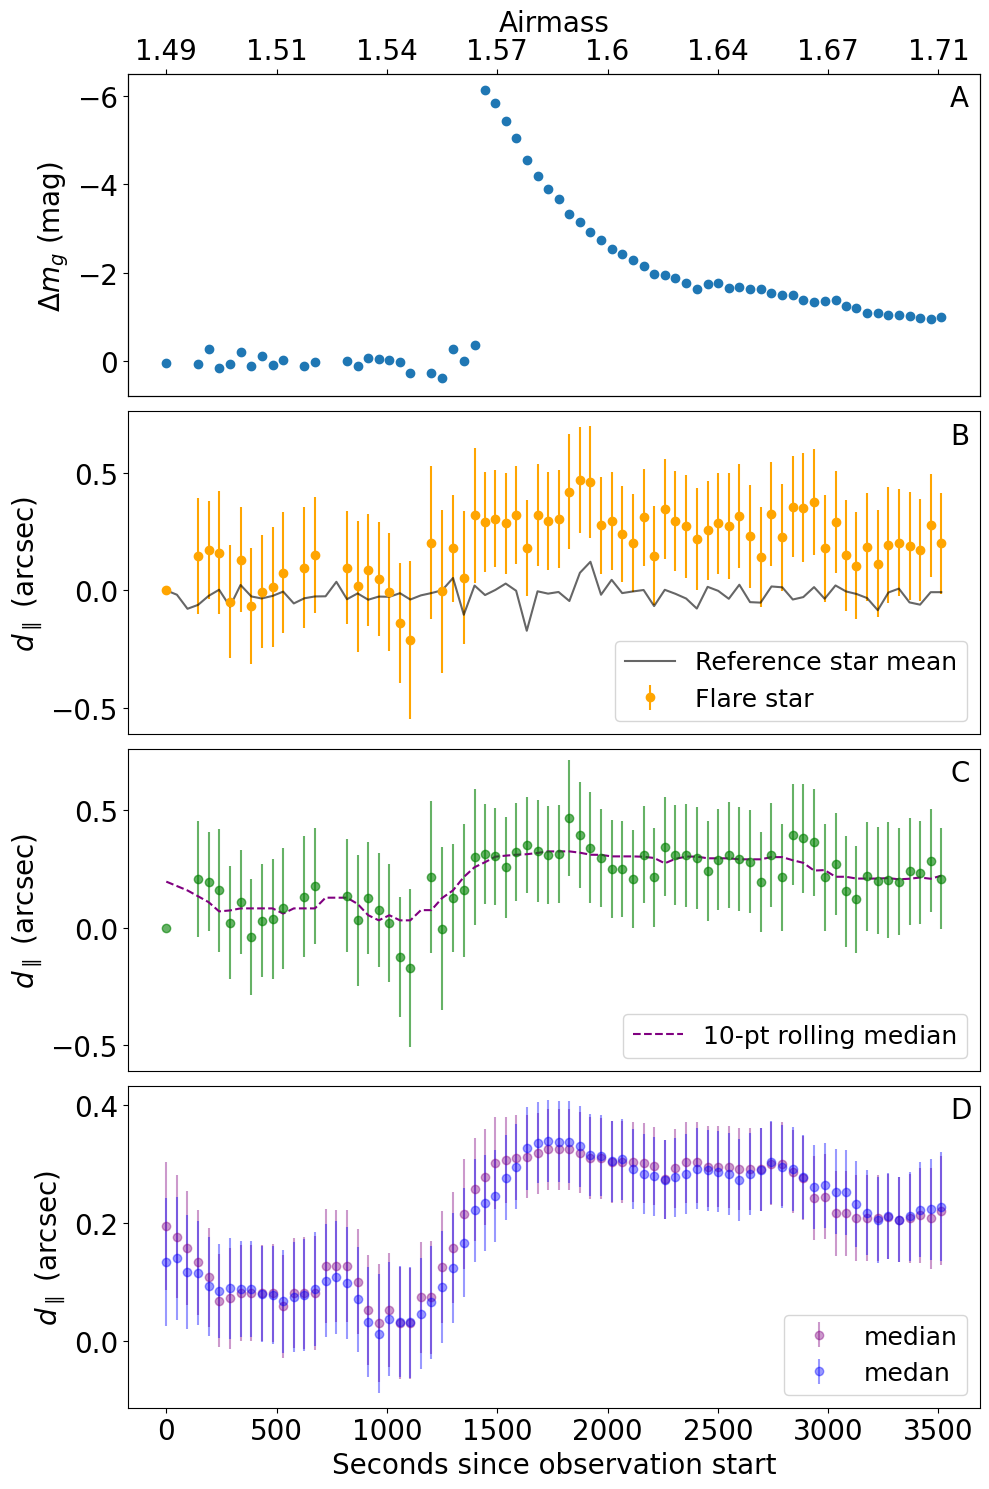

In [81]:

PLOT =True
if PLOT:
    fig, ax = plt.subplots(4,1, figsize=(10,15))

    ax[0].errorbar(flare_df.time, flare_df.g_mag, yerr = flare_df.g_mag_error, 
                   color='C0', marker='o', ls='None')
    ax[0].set_ylabel(r'$\Delta m_g$ (mag)', fontsize=14)
    ax[0].set_ylim(ax[0].get_ylim()[::-1])
    ax[0].set_xticks([])

    ax[1].errorbar(flare_df.time, flare_df.dpar_raw, yerr = flare_df.dpar_error, color='orange', marker='o', ls='None', label='Flare star')
    ax[1].plot(flare_df.time, flare_df.ensamble_dpar, c='k', alpha = 0.6, label='Reference star mean')
    #ax[0].set_xlabel('Seconds since observation start')
    ax[1].set_ylabel(r'$d_\parallel$ (arcsec)', fontsize=14)
    #ax[1].set_title(r'Flare Star $\Delta$DCR', fontsize=14)
    ax[1].legend(loc='lower right', fontsize=18)
    ax[1].set_xticks([])

    ax[2].errorbar(flare_df.time, flare_df.dpar_detrended, yerr = flare_df.dpar_detrended_err, 
                color='green', marker='o', alpha=0.6, ls='None')
    ax[2].plot(flare_df.time, dpar_smoothed, color='purple', ls='--', label='{}-pt rolling median'.format(window))

    #ax[2].set_title(r'Subtracted Flare Star $\Delta$DCR', fontsize=14)
    ax[2].set_ylabel(r'$d_\parallel$ (arcsec)', fontsize=14)
    ax[2].set_ylim(ax[1].get_ylim())
    ax[2].legend(loc='lower right', fontsize=18)
    ax[2].set_xticks([])

    ax[3].errorbar(flare_df.time, flare_df.dpar_smoothed, yerr = flare_df.dparerr_smoothed, 
                   color='purple', alpha=0.4, ls='None', marker='o', label="median")
    ax[3].errorbar(flare_df.time, dpar_smoothedmean, yerr = flare_df.dparerr_smoothed, 
                   color='blue', alpha=0.4, ls='None', marker='o', label="medan")
    ax[3].set_xlabel('Seconds since observation start', fontsize=14)
    ax[3].set_ylabel(r'$d_\parallel$ (arcsec)', fontsize=14)
    #ax[3].set_title(r'Subtracted + Smoothed Flare Star $\Delta$DCR', fontsize=14)
    ax[3].legend(loc='lower right', fontsize=18)
    
    subax0 = ax[0].twiny()
    subax0.set_xticks(ax[3].get_xticks())
    subax0.set_xticklabels(np.round(AM[::8], decimals=2), fontsize=12)
    subax0.set_xlim(ax[0].get_xlim())
    subax0.set_xlabel('Airmass', fontsize=20)
    subax0.tick_params(labelsize=20)

    for axis, label in zip(ax, ['A', 'B', 'C', 'D']):
        axis.annotate(label, xy=(0.965,0.9), xycoords='axes fraction', fontsize=20)
        axis.tick_params(axis='both', labelsize=20)
        axis.set_xlabel(axis.get_xlabel(), fontsize=20)
        axis.set_ylabel(axis.get_ylabel(), fontsize=20)


    fig.tight_layout()

    plt.savefig('Figures/subtractedrolled_dpar.png', dpi = 300, bbox_inches='tight')

np.save('Outdata/dpar_smoothed.npy', dpar_smoothed)
np.save('Outdata/dparerr_smoothed.npy', dparerr_smoothed)

In [73]:
def calculate_reduced_chi_squared(observed, expected_value, errors):
    """
    Calculate the reduced chi-squared statistic.

    Parameters:
    observed (array-like): The observed values (e.g., dpar_subtracted).
    expected_value (float): The single expected value to compare against.
    errors (array-like): The errors associated with the observed values.

    Returns:
    float: The reduced chi-squared statistic.
    """
    # Ensure the arrays are numpy arrays for consistency
    observed = np.array(observed)
    errors = np.array(errors)

    # Calculate the chi-squared statistic
    chi_squared = np.nansum((observed - expected_value) ** 2 / errors ** 2)

    # Calculate the degrees of freedom
    degrees_of_freedom = len(observed[~np.isnan(observed)]) - 1

    # Return the reduced chi-squared statistic
    return chi_squared / degrees_of_freedom

Reduced chi square = 0.3030770627765246


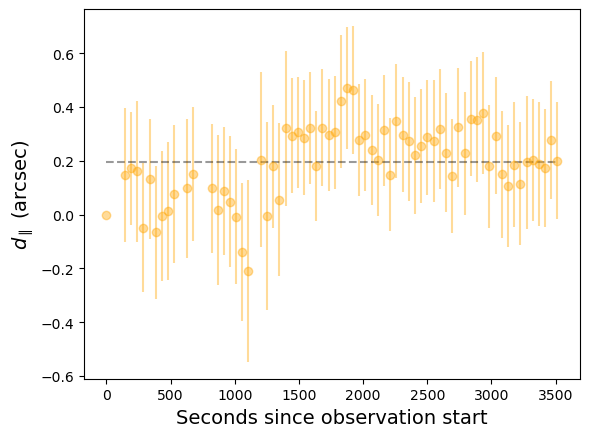

In [74]:
lineVal = np.nanmean(dpar_raw)#[tSec < 1000])

chi_squared = calculate_reduced_chi_squared(dpar_raw, lineVal, dparerr)

plt.errorbar(tSec, dpar_raw, yerr = dparerr, color='orange', alpha=0.4, ls='None', marker='o')
plt.plot(tSec, np.full_like(dpar_raw, lineVal), color='k', alpha=0.4, ls='--')
plt.xlabel('Seconds since observation start', fontsize=14)
plt.ylabel(r'$d_\parallel$ (arcsec)', fontsize=14)

print("Reduced chi square = {}".format(chi_squared))

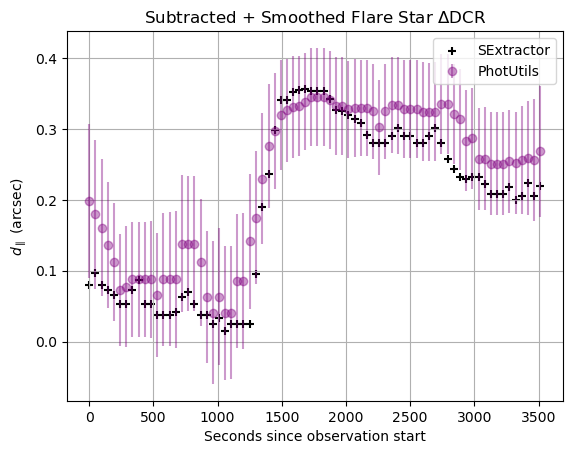

In [75]:
dparsex = np.load('Outdata/dpar_sextractor.npy')

plt.errorbar(tSec, dpar_smoothed, yerr = dparerr_smoothed, color='purple', alpha=0.4, ls='None', marker='o', label='PhotUtils')
plt.scatter(tSec, dparsex, color='k', ls='None', marker='+', label='SExtractor', zorder=0)

plt.xlabel('Seconds since observation start')
plt.ylabel(r'$d_\parallel$ (arcsec)')
plt.title(r'Subtracted + Smoothed Flare Star $\Delta$DCR')
plt.grid()
plt.legend()

In [76]:
##Saving data required for analysis to Outdata
#.npy
np.save('Outdata/dpar_arr.npy', dpar_arr)
np.save('Outdata/dpar_raw.npy', dpar_raw)
np.save('Outdata/dpar_subtracted.npy', dpar_subtracted)
np.save('Outdata/dparerr.npy', dparerr)
np.save('Outdata/delta_g_mag.npy', delta_g_mag)
np.save('Outdata/delta_g_mag_err.npy', delta_g_mag_err)
np.save('Outdata/times.npy', times)

#.csv
np.savetxt('Outdata/delta_g_mag.csv', delta_g_mag)